In [1]:
from default import *


Using TensorFlow backend.


('shape of encoded', (None, 4, 4, 8))
('shape of decoded', (None, 28, 28, 1))
(4.9065221349750372, 'norm')
(4.9328083232677917, 'norm')
(4.9163800976328105, 'norm')
(4.8974911579297418, 'norm')
(4.8839201486203683, 'norm')
(4.8650370931576665, 'norm')
(4.9369831784299203, 'norm')
(4.9285308875769456, 'norm')
(4.8947065470873738, 'norm')
(4.8442648212499693, 'norm')
((1960, 128), 'digits')
((20, 128), 'good digits')
(array([  9.99999523e-01,   1.54240024e-11,   1.26890045e-08,
         2.48430831e-10,   1.05201163e-08,   2.78579648e-07,
         2.60716302e-08,   3.35744543e-09,   1.32378786e-09,
         6.20712726e-08], dtype=float32), 'preds')
(0.92684948, 'activation mean')
(0.22562473, 'activation sd')


In [2]:
import numpy.linalg as nla
import scipy.linalg as sla
target=tf.placeholder("float",shape=(10,))

generator = Sequential([decoder,cnn])
generatorPre = Sequential([decoder]+cnn.layers[:-1])
gradients = tf.gradients(generator.output, generator.input,grad_ys=target)
good_mean,good_cov,good_samples=mean_cov(encoded,lower_thresh=.1,upper_thresh=4)

(4.9065221349750372, 'norm')
(4.9328083232677917, 'norm')
(4.9163800976328105, 'norm')
(4.8974911579297418, 'norm')
(4.8839201486203683, 'norm')
(4.8650370931576665, 'norm')
(4.9369831784299203, 'norm')
(4.9285308875769456, 'norm')
(4.8947065470873738, 'norm')
(4.8442648212499693, 'norm')
((1960, 128), 'digits')
((1305, 128), 'good digits')


In [3]:
import time
import numpy.linalg as nla
import numpy.random as nrand

zcov = np.abs(cov).sum(axis=1)==0
zmean = (mean==0)
cov_safe = cov +np.eye(len(zcov))
cho=sla.cho_factor(cov_safe)

def getLL(points):
    centered=(points.reshape(-1,128)-mean[np.newaxis,:])
    return -(centered.T*sla.cho_solve(cho,centered.T)).sum(axis=0)

def getLLgradient(points):
    centered = (points.reshape(-1,128)-mean[np.newaxis,:])
    grads = -sla.cho_solve(cho,centered.T).T
    return grads.reshape(-1,4,4,8)

def getCentered(points):
    centered=(points.reshape(-1,128)-mean[np.newaxis,:])
    return centered


target_array = np.zeros(10)
target_array[0] = 1

def getActivations(arr):
    global generator,target_array
    return (generator.predict(arr)*target_array).sum(axis=1)

def getActivationsPre(arr):
    global generatorPre,target_array
    return (generatorPre.predict(arr.reshape(-1,4,4,8))*target_array).sum(axis=1)

def norm(arr):
    for i in range(len(arr.shape)-1):
        arr=nla.norm(arr,axis=-1)
    return arr+1e-8

def normalized(a):
    return a/norm(a)[:,None,None,None]
        
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def optimizeSamples(samples,num_iters=10,step_size=1e-5):
    sess = K.get_session()
    current = samples.copy()
    for i in range(num_iters):
        fd={generator.input:current,K.learning_phase(): 0,target:target_array}
        evaluated_gradients = sess.run(gradients,feed_dict=fd)[0]
        ll_gradients = getLLgradient(current)
        #current-=step_size*nla.norm(evaluated_gradients)
        #current+=step_size*(0*nla.norm(evaluated_gradients)+nla.norm(ll_gradients))
        current+= 1e-2 *evaluated_gradients + 1e-3 * ll_gradients
    return current


In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return true;
}

<IPython.core.display.Javascript object>

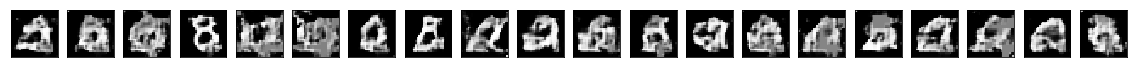

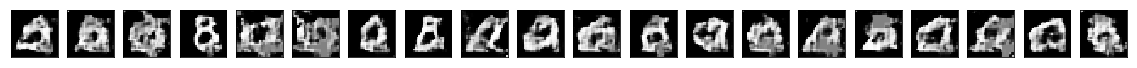

[ 0.19606866  0.55650902  0.4892804  ...,  0.81147176  0.12533747
  0.35268328]
[ 0.99606186  0.91140479  0.89628011 ...,  0.96467263  0.99424416
  0.9650808 ]


In [5]:
def print_images(decoded_imgs,max_num=20):
    n = min(max_num,len(decoded_imgs))
    for i in range(n):
        if i%20 == 0:
            plt.figure(figsize=(20, 4))
        # display reconstruction
        ax = plt.subplot(2, 20, i %20 + 1 )
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i%20 == 19:
            plt.show()
    plt.show()

def print_codes(codes,max_num=20):
    print_images(decoder.predict(codes.reshape(-1,4,4,8)),max_num)
    
def filterMedActs(samples):
    acts=getActivations(samples)
    return samples[np.logical_and(.12<acts,acts<.9)]

mediums = filterMedActs(good_samples)
opt_samples = optimizeSamples(mediums)
print_images(decoder.predict(mediums))
print_images(decoder.predict(opt_samples))
print(getActivations(mediums))
print(getActivations(opt_samples))
# print(getLL(good_samples))
# print(getLL(opt_samples))

(1003, 4, 4, 8)


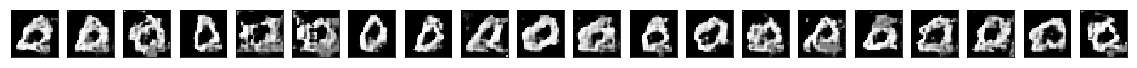

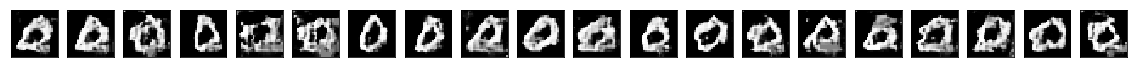

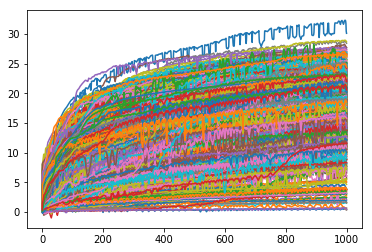

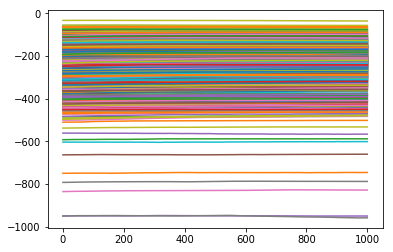

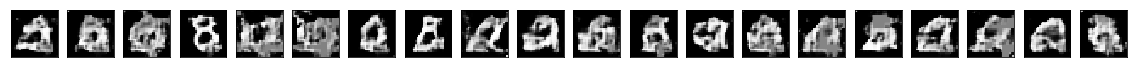

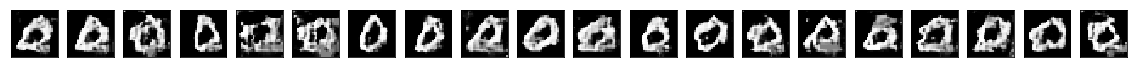

In [21]:
def filterMedActs(samples):
    acts=getActivations(samples)
    return samples[np.logical_and(.12<acts,acts<.8)]

print(filterMedActs(good_samples).shape)
generator = Sequential([decoder,cnn])
generatorPre = Sequential(decoder.layers+cnn.layers[:-1]+[Activation("linear")])
target=tf.placeholder("float",shape=(None,10,))

def chartSamples(samples,num_iters=100,num_sub=10,step_size=1e-1,generator=generator):
    step_size/=num_sub
    sess = K.get_session()
    current = samples.copy()
    activation_history = [getActivations(current)]
    ll_history = [getLL(current)]
    point_history = [current.copy()]
    target=tf.placeholder("float",shape=(None,10,))
    target_array = np.zeros((samples.shape[0],10))
    target_array[:,0] = 1
    gradients = tf.gradients(generator.output, generator.input,grad_ys=target)
    for i in range(num_iters):
        fd={generator.input:current,K.learning_phase(): 0,target:target_array}
        evaluated_gradients = sess.run(gradients,feed_dict=fd)[0]
        ll_gradients = getLLgradient(current)
        norm_eg=normalized(evaluated_gradients)
        norm_ll=normalized(ll_gradients)
        for _ in range(num_sub):
            current+=step_size*norm_eg
            activations = getActivationsPre(current)
            activation_history += [activations]
            ll_history +=[getLL(current)]
            point_history +=[current.copy()]
        if (i+1)%50==0:
            print_codes(current)
            
    for row in np.array(activation_history).T:
        plt.plot(row)
    plt.show()
#     for row in np.array(ll_history).T:
#         plt.plot(row)
#     plt.show()
    return point_history


medium_opt=chartSamples(mediums,generator=generatorPre)[-1]
print_codes(mediums)
print_codes(medium_opt)
# #print(getActivations(mediums))
# print(getLL(mediums))
# #print(getActivations(medium_opt))
# print(getLL(medium_opt))

In [7]:
#white_noise = nrand.uniform(size=(10,28,28,1))
#print_codes(encoder.predict(white_noise))
#chartSamples(encoder.predict(white_noise))

In [8]:
%load_ext autoreload
%aimport -default
%autoreload 2


In [32]:
def print_codes(codes,max_num=20):
    print_images(decoder.predict(codes.reshape(-1,4,4,8)),max_num)

target_array = np.zeros(10)
target_array[0] = 1

def plotHistory(resultsList):
    steps=np.array(resultsList)
    #fig, ax = plt.subplots()
    u = plt.plot([metric(x,getActivationsPre) for x in steps],label="Perturbation Metric",color="black")
    d = plt.plot(getActivationsPre(steps),linestyle=":",label="Objective Function",color="black")
    plt.legend()
    plt.show()
    print_codes(np.array(resultsList))


def cmaObjective(arr):
    global generator,generatorPre,target_array
    return -(generatorPre.predict(arr.reshape(-1,4,4,8))*target_array).sum(axis=1)
#print(cmaObjective(good_samples[:1].reshape(1,128)))

def metric(sample, activation_fn, n=200, eps=0.1, percentile = .1):
    sample = sample.reshape(1,4,4,8)
    results = []
    noise = nrand.normal(size=(n,4,4,8), scale=eps)
    noised_sample = sample + noise
    results=activation_fn(noised_sample)
    results.sort()
    return results[int(n*percentile)]

import cma
from threading import Thread


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -6.745878458023071e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -5.380183696746826e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -2.989623069763184e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.1
  100   1500 -2.777884101867676e+01 1.3e+00 7.32e-01  7e-01  7e-01 0:01.5
  200   3000 -3.651372909545898e+01 1.5e+00 6.29e-01  6e-01  6e-01 0:03.0
  300   4500 -4.184246826171875e+01 1.6e+00 4.84e-01  5e-01  5e-01 0:04.4
  400   6000 -4.509973144531250e+01 1.7e+00 3.56e-01  3e-01  4e-01 0:05.9
  500   7500 -4.682741928100586e+01 1.8e+00 2.30e-01  2e-01  2e-01 0:07.3


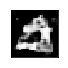

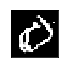

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.132964611053467e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -3.222677230834961e+00 1.0e+00 9.46e-01  9e-01  9e-01 0:00.0
    3     45 -4.251576960086823e-01 1.0e+00 9.27e-01  9e-01  9e-01 0:00.1
WARNING (module=cma.utilities.utils, iteration=16):  flat fitness (sigma=8.23e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=16):  flat fitness (sigma=8.23e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=18):  flat fitness (sigma=8.22e-01).
                    For small sigma, this could indicate numerical convergence.
                    Ot

WARNING (module=cma.utilities.utils, iteration=54):  flat fitness (sigma=9.00e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=54):  flat fitness (sigma=9.00e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=56):  flat fitness (sigma=9.02e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=56):  flat fitness (sigma=9.02e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=78):  flat fitness (sigma=8.67e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=78):  flat fitness (sigma=8.67e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=79):  flat fitness (sigma=8.63e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=79):  flat fitness (sigma=8.63e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=112):  flat fitness (sigma=8.48e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=112):  flat fitness (sigma=8.48e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=113):  flat fitness (sigma=8.51e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=113):  flat fitness (sigma=8.51e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=131):  flat fitness (sigma=8.88e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=131):  flat fitness (sigma=8.88e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=132):  flat fitness (sigma=8.89e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=132):  flat fitness (sigma=8.89e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=148):  flat fitness (sigma=8.90e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=148):  flat fitness (sigma=8.90e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=149):  flat fitness (sigma=8.87e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=149):  flat fitness (sigma=8.87e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=169):  flat fitness (sigma=8.68e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=169):  flat fitness (sigma=8.68e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=170):  flat fitness (sigma=8.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=170):  flat fitness (sigma=8.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=185):  flat fitness (sigma=9.07e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=185):  flat fitness (sigma=9.07e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=186):  flat fitness (sigma=9.08e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=186):  flat fitness (sigma=9.08e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=208):  flat fitness (sigma=9.15e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=208):  flat fitness (sigma=9.15e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=209):  flat fitness (sigma=9.17e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=209):  flat fitness (sigma=9.17e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=225):  flat fitness (sigma=9.53e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=225):  flat fitness (sigma=9.53e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=226):  flat fitness (sigma=9.57e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=226):  flat fitness (sigma=9.57e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=241):  flat fitness (sigma=9.96e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=241):  flat fitness (sigma=9.96e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=242):  flat fitness (sigma=9.94e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=242):  flat fitness (sigma=9.94e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=258):  flat fitness (sigma=9.57e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=258):  flat fitness (sigma=9.57e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=259):  flat fitness (sigma=9.59e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=259):  flat fitness (sigma=9.59e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=288):  flat fitness (sigma=1.05e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=288):  flat fitness (sigma=1.05e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=289):  flat fitness (sigma=1.05e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=289):  flat fitness (sigma=1.05e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=308):  flat fitness (sigma=1.01e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
  308   4620 -4.631068930029869e-02 1.5e+00 1.01e+00  1e+00  1e+00 0:04.8
WARNING (module=cma.utilities.utils, iteration=308):  flat fitness (sigma=1.01e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.


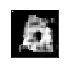

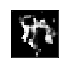

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.394981622695923e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -2.155328512191772e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -5.236403942108154e+00 1.0e+00 9.18e-01  9e-01  9e-01 0:00.0
  100   1500 -2.779285812377930e+01 1.3e+00 7.98e-01  8e-01  8e-01 0:01.4
  200   3000 -3.546077728271484e+01 1.5e+00 6.75e-01  7e-01  7e-01 0:02.9
  300   4500 -3.116611671447754e+01 1.6e+00 7.40e-01  7e-01  8e-01 0:04.3
  400   6000 -3.943828582763672e+01 1.6e+00 4.34e-01  4e-01  4e-01 0:05.8
  500   7500 -4.115105056762695e+01 1.7e+00 3.85e-01  4e-01  4e-01 0:07.3


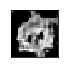

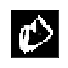

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.084928989410400e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -6.257049083709717e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -8.624488830566406e+00 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -2.456056785583496e+01 1.3e+00 7.56e-01  7e-01  8e-01 0:01.5
  200   3000 -3.198780441284180e+01 1.5e+00 6.29e-01  6e-01  6e-01 0:03.0
  300   4500 -3.300113296508789e+01 1.6e+00 4.90e-01  5e-01  5e-01 0:04.5
  400   6000 -3.609427261352539e+01 1.7e+00 3.43e-01  3e-01  4e-01 0:05.9
  500   7500 -3.636894226074219e+01 1.7e+00 2.55e-01  2e-01  3e-01 0:07.6


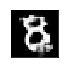

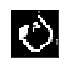

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -7.400273680686951e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -1.537688523530960e-01 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -1.898349672555923e-01 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -2.509763717651367e+01 1.3e+00 6.41e-01  6e-01  6e-01 0:01.5
  200   3000 -3.423965835571289e+01 1.5e+00 4.59e-01  4e-01  5e-01 0:03.0
  300   4500 -3.725528335571289e+01 1.5e+00 3.31e-01  3e-01  3e-01 0:04.5
  400   6000 -3.971129608154297e+01 1.7e+00 2.63e-01  2e-01  3e-01 0:06.0
  500   7500 -4.034766387939453e+01 1.8e+00 1.96e-01  2e-01  2e-01 0:07.7


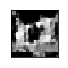

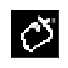

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.259066343307495e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -7.714220285415649e-01 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -2.990158200263977e-01 1.0e+00 9.19e-01  9e-01  9e-01 0:00.0
  100   1500 -2.512706375122070e+01 1.3e+00 6.91e-01  7e-01  7e-01 0:01.5
  200   3000 -3.069102096557617e+01 1.5e+00 5.72e-01  5e-01  6e-01 0:03.1
  300   4500 -3.378407669067383e+01 1.6e+00 4.16e-01  4e-01  4e-01 0:05.0
  400   6000 -3.818563461303711e+01 1.7e+00 3.02e-01  3e-01  3e-01 0:06.4
  500   7500 -3.800988006591797e+01 1.8e+00 2.15e-01  2e-01  2e-01 0:07.9


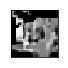

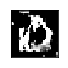

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -5.990815162658691e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.702287077903748e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -2.840863943099976e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -3.156717872619629e+01 1.3e+00 6.17e-01  6e-01  6e-01 0:01.5
  200   3000 -3.496268844604492e+01 1.5e+00 5.22e-01  5e-01  5e-01 0:03.0
  300   4500 -3.705052566528320e+01 1.5e+00 4.01e-01  4e-01  4e-01 0:04.5
  400   6000 -3.752855682373047e+01 1.6e+00 3.02e-01  3e-01  3e-01 0:06.0
  500   7500 -3.948381042480469e+01 1.6e+00 1.94e-01  2e-01  2e-01 0:07.5


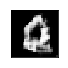

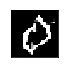

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -4.156165122985840e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.306236505508423e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -7.372253894805908e+00 1.0e+00 9.19e-01  9e-01  9e-01 0:00.0
  100   1500 -2.761191558837891e+01 1.3e+00 7.45e-01  7e-01  8e-01 0:01.7
  200   3000 -3.184405708312988e+01 1.5e+00 6.14e-01  6e-01  6e-01 0:03.1
  300   4500 -3.644563293457031e+01 1.5e+00 4.42e-01  4e-01  5e-01 0:04.7
  400   6000 -3.794686508178711e+01 1.6e+00 3.34e-01  3e-01  3e-01 0:06.3
  500   7500 -3.886695098876953e+01 1.7e+00 2.02e-01  2e-01  2e-01 0:07.7


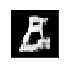

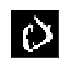

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -4.062632083892822e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -3.320959091186523e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -5.322864532470703e+00 1.0e+00 9.18e-01  9e-01  9e-01 0:00.0
  100   1500 -3.196896171569824e+01 1.3e+00 7.55e-01  7e-01  8e-01 0:01.5
  200   3000 -3.632740783691406e+01 1.5e+00 6.20e-01  6e-01  6e-01 0:03.1
  300   4500 -3.841250610351562e+01 1.6e+00 4.80e-01  5e-01  5e-01 0:04.5
  400   6000 -3.910495376586914e+01 1.6e+00 4.28e-01  4e-01  4e-01 0:06.0
  500   7500 -3.896583938598633e+01 1.7e+00 3.44e-01  3e-01  4e-01 0:07.5


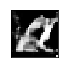

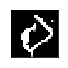

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.655397653579712e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -1.163377380371094e+01 1.0e+00 9.40e-01  9e-01  9e-01 0:00.0
    3     45 -3.408805847167969e+00 1.0e+00 9.16e-01  9e-01  9e-01 0:00.0
  100   1500 -2.879847335815430e+01 1.4e+00 7.53e-01  7e-01  8e-01 0:01.5
  200   3000 -3.652903747558594e+01 1.6e+00 6.46e-01  6e-01  7e-01 0:02.9
  300   4500 -3.965534591674805e+01 1.7e+00 4.35e-01  4e-01  5e-01 0:04.3
  400   6000 -4.156577301025391e+01 1.8e+00 3.28e-01  3e-01  3e-01 0:05.7
  500   7500 -4.181208801269531e+01 1.9e+00 2.55e-01  2e-01  3e-01 0:07.3


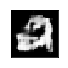

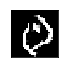

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.760133028030396e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -4.020845413208008e+00 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -2.998350143432617e+00 1.0e+00 9.24e-01  9e-01  9e-01 0:00.0
  100   1500 -3.232537460327148e+01 1.3e+00 6.09e-01  6e-01  6e-01 0:01.4
  200   3000 -3.600567626953125e+01 1.4e+00 4.73e-01  5e-01  5e-01 0:02.9
  300   4500 -4.022140502929688e+01 1.5e+00 3.60e-01  3e-01  4e-01 0:04.5
  400   6000 -4.180205917358398e+01 1.6e+00 2.62e-01  2e-01  3e-01 0:05.9
  500   7500 -4.319518280029297e+01 1.7e+00 2.11e-01  2e-01  2e-01 0:07.4


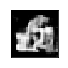

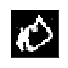

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.124496078491211e+01 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -4.778143882751465e+00 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -1.039826011657715e+01 1.0e+00 9.26e-01  9e-01  9e-01 0:00.0
  100   1500 -2.751889801025391e+01 1.3e+00 6.73e-01  7e-01  7e-01 0:01.5
  200   3000 -3.322837829589844e+01 1.4e+00 5.43e-01  5e-01  6e-01 0:03.0
  300   4500 -3.847640991210938e+01 1.6e+00 4.57e-01  4e-01  5e-01 0:04.5
  400   6000 -4.155940246582031e+01 1.7e+00 3.79e-01  4e-01  4e-01 0:06.0
  500   7500 -4.330348587036133e+01 1.7e+00 2.67e-01  3e-01  3e-01 0:07.6


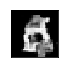

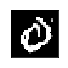

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -9.178494811058044e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -5.941577911376953e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -2.584422588348389e+00 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -3.268011856079102e+01 1.3e+00 5.96e-01  6e-01  6e-01 0:01.6
  200   3000 -3.821657180786133e+01 1.5e+00 5.29e-01  5e-01  6e-01 0:03.4
  300   4500 -3.872299957275391e+01 1.5e+00 3.52e-01  3e-01  4e-01 0:05.2
  400   6000 -4.057483673095703e+01 1.6e+00 2.70e-01  2e-01  3e-01 0:07.1
  500   7500 -4.151717758178711e+01 1.7e+00 1.89e-01  2e-01  2e-01 0:08.9


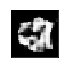

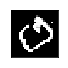

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -7.964950203895569e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.759816884994507e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -2.578338384628296e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -2.891003799438477e+01 1.3e+00 5.73e-01  6e-01  6e-01 0:01.4
  200   3000 -3.410421371459961e+01 1.4e+00 4.16e-01  4e-01  4e-01 0:02.9
  300   4500 -3.629857635498047e+01 1.5e+00 2.97e-01  3e-01  3e-01 0:04.5
  400   6000 -3.817232513427734e+01 1.5e+00 2.17e-01  2e-01  2e-01 0:06.1
  500   7500 -4.011603546142578e+01 1.6e+00 1.74e-01  2e-01  2e-01 0:07.7


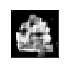

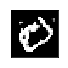

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -5.317743301391602e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -7.046377182006836e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -8.999591827392578e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -2.981001472473145e+01 1.3e+00 5.99e-01  6e-01  6e-01 0:01.4
  200   3000 -3.184143257141113e+01 1.5e+00 5.72e-01  5e-01  6e-01 0:03.1
  300   4500 -3.785863113403320e+01 1.6e+00 3.94e-01  4e-01  4e-01 0:04.7
  400   6000 -4.031085586547852e+01 1.7e+00 3.13e-01  3e-01  3e-01 0:06.4
  500   7500 -4.080990600585938e+01 1.7e+00 2.43e-01  2e-01  3e-01 0:07.9


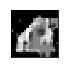

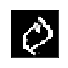

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -5.836874842643738e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.426017522811890e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -9.695321321487427e-01 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -2.692988586425781e+01 1.4e+00 7.13e-01  7e-01  7e-01 0:01.4
  200   3000 -3.206130218505859e+01 1.4e+00 5.05e-01  5e-01  5e-01 0:02.9
  300   4500 -3.581907653808594e+01 1.5e+00 3.78e-01  4e-01  4e-01 0:04.4
  400   6000 -3.782307434082031e+01 1.6e+00 2.72e-01  3e-01  3e-01 0:05.8
  500   7500 -3.901580047607422e+01 1.6e+00 1.95e-01  2e-01  2e-01 0:07.4


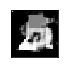

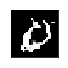

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -5.519015789031982e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -4.676366329193115e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -4.361076354980469e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -2.934532356262207e+01 1.4e+00 7.75e-01  8e-01  8e-01 0:01.5
  200   3000 -3.810588455200195e+01 1.4e+00 5.46e-01  5e-01  6e-01 0:03.1
  300   4500 -4.092931365966797e+01 1.5e+00 4.56e-01  4e-01  5e-01 0:04.6
  400   6000 -4.242348098754883e+01 1.6e+00 3.79e-01  3e-01  4e-01 0:06.0
  500   7500 -4.403237152099609e+01 1.7e+00 2.96e-01  3e-01  3e-01 0:07.4


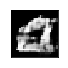

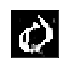

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.879916071891785e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.303541064262390e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -2.403089046478271e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -2.050605583190918e+01 1.3e+00 7.77e-01  8e-01  8e-01 0:01.5
  200   3000 -2.640519714355469e+01 1.5e+00 6.51e-01  6e-01  7e-01 0:03.0
  300   4500 -2.942527961730957e+01 1.6e+00 5.52e-01  5e-01  6e-01 0:04.5
  400   6000 -3.076457023620605e+01 1.7e+00 4.11e-01  4e-01  4e-01 0:06.0
  500   7500 -3.384547424316406e+01 1.7e+00 3.04e-01  3e-01  3e-01 0:07.6


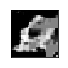

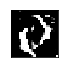

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -7.471710443496704e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.153140962123871e-01 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -1.128816455602646e-01 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -2.240818977355957e+01 1.3e+00 7.37e-01  7e-01  7e-01 0:01.6
  200   3000 -2.687183761596680e+01 1.5e+00 5.17e-01  5e-01  5e-01 0:03.1
  300   4500 -3.097216987609863e+01 1.5e+00 4.09e-01  4e-01  4e-01 0:04.5
  400   6000 -3.215538024902344e+01 1.7e+00 3.22e-01  3e-01  3e-01 0:06.2
  500   7500 -3.269898223876953e+01 1.8e+00 3.70e-01  3e-01  4e-01 0:07.8


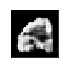

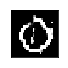

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -6.801464557647705e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.114507198333740e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -6.012163162231445e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -2.766933441162109e+01 1.3e+00 6.30e-01  6e-01  6e-01 0:01.4
  200   3000 -3.492569351196289e+01 1.5e+00 5.67e-01  5e-01  6e-01 0:03.1
  300   4500 -3.845422744750977e+01 1.6e+00 4.67e-01  4e-01  5e-01 0:04.6
  400   6000 -4.132589721679688e+01 1.8e+00 3.62e-01  3e-01  4e-01 0:06.1
  500   7500 -4.044654464721680e+01 1.9e+00 3.57e-01  3e-01  4e-01 0:07.5


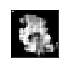

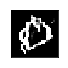

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -6.449413776397705e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -6.017951488494873e+00 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -7.794150829315186e+00 1.0e+00 9.24e-01  9e-01  9e-01 0:00.0
  100   1500 -2.855480003356934e+01 1.3e+00 7.17e-01  7e-01  7e-01 0:01.5
  200   3000 -3.575379943847656e+01 1.5e+00 6.31e-01  6e-01  6e-01 0:03.0
  300   4500 -3.722279357910156e+01 1.5e+00 4.23e-01  4e-01  4e-01 0:04.4
  400   6000 -3.886689758300781e+01 1.6e+00 3.42e-01  3e-01  4e-01 0:05.9
  500   7500 -3.994562149047852e+01 1.7e+00 2.54e-01  2e-01  3e-01 0:07.5


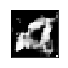

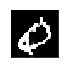

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.937493562698364e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -3.756932020187378e+00 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -3.316620826721191e+00 1.0e+00 9.26e-01  9e-01  9e-01 0:00.0
  100   1500 -3.133362007141113e+01 1.4e+00 8.67e-01  9e-01  9e-01 0:01.5
  200   3000 -3.812454605102539e+01 1.5e+00 6.10e-01  6e-01  6e-01 0:02.9
  300   4500 -3.901860427856445e+01 1.6e+00 4.94e-01  5e-01  5e-01 0:04.4
  400   6000 -4.256288146972656e+01 1.7e+00 3.44e-01  3e-01  4e-01 0:05.8
  500   7500 -4.357561111450195e+01 1.8e+00 2.28e-01  2e-01  2e-01 0:07.4


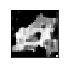

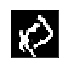

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -6.503522872924805e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.500457882881165e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -1.687544226646423e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -3.148699188232422e+01 1.4e+00 7.29e-01  7e-01  8e-01 0:01.4
  200   3000 -3.620955657958984e+01 1.5e+00 4.96e-01  5e-01  5e-01 0:03.1
  300   4500 -3.725744628906250e+01 1.6e+00 3.86e-01  4e-01  4e-01 0:04.6
  400   6000 -3.972549438476562e+01 1.7e+00 3.46e-01  3e-01  4e-01 0:06.2
  500   7500 -4.061855316162109e+01 1.8e+00 2.66e-01  2e-01  3e-01 0:07.7


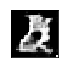

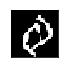

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.870782613754272e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -6.529930233955383e-01 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -2.151988506317139e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -3.300749206542969e+01 1.3e+00 6.27e-01  6e-01  6e-01 0:01.6
  200   3000 -3.558094024658203e+01 1.4e+00 5.31e-01  5e-01  5e-01 0:03.3
  300   4500 -3.737333297729492e+01 1.5e+00 4.48e-01  4e-01  5e-01 0:05.0
  400   6000 -3.928335189819336e+01 1.5e+00 3.00e-01  3e-01  3e-01 0:07.0
  500   7500 -4.033518600463867e+01 1.6e+00 2.47e-01  2e-01  3e-01 0:08.6


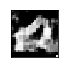

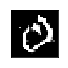

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.606590747833252e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -1.099033594131470e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -1.052727818489075e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -3.058190917968750e+01 1.4e+00 7.96e-01  8e-01  8e-01 0:01.5
  200   3000 -3.669821548461914e+01 1.6e+00 7.15e-01  7e-01  7e-01 0:03.0
  300   4500 -3.939382934570312e+01 1.6e+00 5.34e-01  5e-01  6e-01 0:04.4
  400   6000 -4.134902191162109e+01 1.7e+00 3.75e-01  4e-01  4e-01 0:05.8
  500   7500 -4.185832595825195e+01 1.7e+00 2.50e-01  2e-01  3e-01 0:07.4


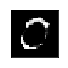

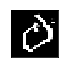

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 1.586115658283234e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.718591213226318e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -6.134511828422546e-01 1.0e+00 9.18e-01  9e-01  9e-01 0:00.0
WARNING (module=cma.utilities.utils, iteration=9):  flat fitness (sigma=8.31e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=9):  flat fitness (sigma=8.31e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=10):  flat fitness (sigma=8.24e-01).
                    For small sigma, this could indicate numerical convergence.
                    Other

WARNING (module=cma.utilities.utils, iteration=28):  flat fitness (sigma=7.62e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=28):  flat fitness (sigma=7.62e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=29):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=29):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=44):  flat fitness (sigma=7.81e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=44):  flat fitness (sigma=7.81e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=45):  flat fitness (sigma=7.77e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=45):  flat fitness (sigma=7.77e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=60):  flat fitness (sigma=7.39e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=60):  flat fitness (sigma=7.39e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=61):  flat fitness (sigma=7.37e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=61):  flat fitness (sigma=7.37e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=76):  flat fitness (sigma=7.47e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=76):  flat fitness (sigma=7.47e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=77):  flat fitness (sigma=7.48e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=77):  flat fitness (sigma=7.48e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=93):  flat fitness (sigma=7.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=93):  flat fitness (sigma=7.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=94):  flat fitness (sigma=7.72e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=94):  flat fitness (sigma=7.72e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=109):  flat fitness (sigma=7.93e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=109):  flat fitness (sigma=7.93e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=110):  flat fitness (sigma=7.92e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=110):  flat fitness (sigma=7.92e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=126):  flat fitness (sigma=7.56e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=126):  flat fitness (sigma=7.56e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=127):  flat fitness (sigma=7.55e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=127):  flat fitness (sigma=7.55e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=142):  flat fitness (sigma=7.76e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=142):  flat fitness (sigma=7.76e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=143):  flat fitness (sigma=7.77e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=143):  flat fitness (sigma=7.77e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=158):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=158):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=159):  flat fitness (sigma=7.63e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=159):  flat fitness (sigma=7.63e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=178):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=178):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=180):  flat fitness (sigma=7.60e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=180):  flat fitness (sigma=7.60e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=196):  flat fitness (sigma=7.33e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=196):  flat fitness (sigma=7.33e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=198):  flat fitness (sigma=7.31e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=198):  flat fitness (sigma=7.31e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=215):  flat fitness (sigma=7.16e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=215):  flat fitness (sigma=7.16e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=216):  flat fitness (sigma=7.15e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=216):  flat fitness (sigma=7.15e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=231):  flat fitness (sigma=7.08e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=231):  flat fitness (sigma=7.08e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=232):  flat fitness (sigma=7.09e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=232):  flat fitness (sigma=7.09e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=247):  flat fitness (sigma=7.25e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=247):  flat fitness (sigma=7.25e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=248):  flat fitness (sigma=7.29e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=248):  flat fitness (sigma=7.29e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=263):  flat fitness (sigma=7.59e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=263):  flat fitness (sigma=7.59e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=264):  flat fitness (sigma=7.59e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=264):  flat fitness (sigma=7.59e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

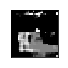

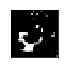

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -8.229291915893555e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.089431524276733e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -6.137801647186279e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -3.081783866882324e+01 1.3e+00 7.53e-01  7e-01  8e-01 0:01.5
  200   3000 -3.287504577636719e+01 1.4e+00 5.58e-01  5e-01  6e-01 0:03.0
  300   4500 -3.547467041015625e+01 1.5e+00 4.17e-01  4e-01  4e-01 0:04.4
  400   6000 -3.901634216308594e+01 1.6e+00 2.91e-01  3e-01  3e-01 0:05.9
  500   7500 -4.140560150146484e+01 1.7e+00 2.23e-01  2e-01  2e-01 0:07.4


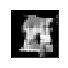

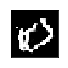

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -5.163297653198242e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -9.066099166870117e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -7.087052822113037e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -3.150729560852051e+01 1.4e+00 7.48e-01  7e-01  8e-01 0:01.5
  200   3000 -3.537659454345703e+01 1.5e+00 6.18e-01  6e-01  6e-01 0:02.9
  300   4500 -3.822533416748047e+01 1.6e+00 3.65e-01  3e-01  4e-01 0:04.4
  400   6000 -3.874210357666016e+01 1.6e+00 3.41e-01  3e-01  4e-01 0:05.9
  500   7500 -3.984196853637695e+01 1.7e+00 2.60e-01  2e-01  3e-01 0:07.4


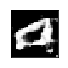

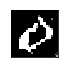

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 6.087250113487244e-01 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 4.921542108058929e-01 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -1.649738192558289e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -2.890291786193848e+01 1.3e+00 6.50e-01  6e-01  7e-01 0:01.4
  200   3000 -3.565609359741211e+01 1.5e+00 5.85e-01  6e-01  6e-01 0:03.0
  300   4500 -3.849539947509766e+01 1.6e+00 4.13e-01  4e-01  4e-01 0:04.4
  400   6000 -3.900171661376953e+01 1.7e+00 3.09e-01  3e-01  3e-01 0:05.9
  500   7500 -3.912931823730469e+01 1.7e+00 2.47e-01  2e-01  3e-01 0:07.4


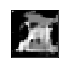

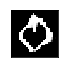

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.739014863967896e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.203088521957397e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -1.458285927772522e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -2.883061790466309e+01 1.4e+00 7.73e-01  8e-01  8e-01 0:01.6
  200   3000 -3.570650863647461e+01 1.6e+00 6.14e-01  6e-01  6e-01 0:03.2
  300   4500 -3.881317520141602e+01 1.7e+00 4.37e-01  4e-01  4e-01 0:04.7
  400   6000 -4.033681488037109e+01 1.7e+00 2.99e-01  3e-01  3e-01 0:06.3
  500   7500 -4.186275863647461e+01 1.7e+00 1.90e-01  2e-01  2e-01 0:07.8


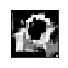

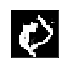

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 1.159616559743881e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.813997268676758e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -4.109694957733154e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -2.994080543518066e+01 1.3e+00 6.85e-01  7e-01  7e-01 0:01.4
  200   3000 -3.623212432861328e+01 1.5e+00 6.49e-01  6e-01  7e-01 0:02.9
  300   4500 -3.884771347045898e+01 1.5e+00 5.05e-01  5e-01  5e-01 0:04.4
  400   6000 -4.017543792724609e+01 1.6e+00 3.28e-01  3e-01  3e-01 0:05.8
  500   7500 -4.079486465454102e+01 1.7e+00 2.84e-01  3e-01  3e-01 0:07.4


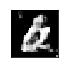

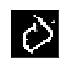

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.776362001895905e-02 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -4.898255765438080e-01 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -1.835920959711075e-01 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -2.819386863708496e+01 1.3e+00 7.27e-01  7e-01  7e-01 0:01.4
  200   3000 -3.278178787231445e+01 1.4e+00 5.65e-01  5e-01  6e-01 0:02.9
  300   4500 -3.602525329589844e+01 1.5e+00 4.77e-01  4e-01  5e-01 0:04.4
  400   6000 -3.741463851928711e+01 1.6e+00 3.90e-01  3e-01  4e-01 0:05.9
  500   7500 -3.991704559326172e+01 1.7e+00 3.22e-01  3e-01  3e-01 0:07.4


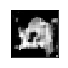

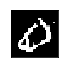

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.854060769081116e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -2.654467582702637e+00 1.0e+00 9.39e-01  9e-01  9e-01 0:00.0
    3     45 -1.056892156600952e+00 1.0e+00 9.15e-01  9e-01  9e-01 0:00.0
  100   1500 -1.573100757598877e+01 1.3e+00 8.27e-01  8e-01  8e-01 0:01.4
  200   3000 -2.337520790100098e+01 1.4e+00 6.47e-01  6e-01  7e-01 0:02.9
  300   4500 -2.897495460510254e+01 1.5e+00 5.12e-01  5e-01  5e-01 0:04.4
  400   6000 -2.894895553588867e+01 1.6e+00 4.68e-01  4e-01  5e-01 0:05.9
  500   7500 -3.308311462402344e+01 1.7e+00 3.56e-01  3e-01  4e-01 0:07.5


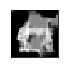

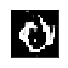

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -8.822330236434937e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -4.901441574096680e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -8.463615417480469e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -2.500055122375488e+01 1.4e+00 8.19e-01  8e-01  8e-01 0:01.4
  200   3000 -3.102824783325195e+01 1.5e+00 6.44e-01  6e-01  7e-01 0:03.0
  300   4500 -3.666075134277344e+01 1.5e+00 5.32e-01  5e-01  6e-01 0:04.5
  400   6000 -3.832860565185547e+01 1.6e+00 4.55e-01  4e-01  5e-01 0:05.9
  500   7500 -3.866583251953125e+01 1.7e+00 2.84e-01  3e-01  3e-01 0:07.4


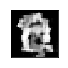

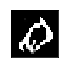

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.367645263671875e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -6.288077831268311e-01 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -1.233091473579407e+00 1.0e+00 9.19e-01  9e-01  9e-01 0:00.0
  100   1500 -2.904150772094727e+01 1.3e+00 7.17e-01  7e-01  7e-01 0:01.5
  200   3000 -3.410163497924805e+01 1.5e+00 6.06e-01  6e-01  6e-01 0:03.0
  300   4500 -3.933887100219727e+01 1.5e+00 4.01e-01  4e-01  4e-01 0:04.5
  400   6000 -4.159313964843750e+01 1.6e+00 3.59e-01  3e-01  4e-01 0:06.1
  500   7500 -4.374842453002930e+01 1.7e+00 2.32e-01  2e-01  2e-01 0:07.5


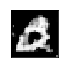

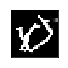

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.875122964382172e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -4.642037391662598e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -3.866877079010010e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -3.268424987792969e+01 1.3e+00 7.34e-01  7e-01  8e-01 0:01.5
  200   3000 -3.335835647583008e+01 1.5e+00 6.36e-01  6e-01  7e-01 0:02.9
  300   4500 -3.755153274536133e+01 1.6e+00 4.43e-01  4e-01  5e-01 0:04.3
  400   6000 -3.751920318603516e+01 1.6e+00 4.43e-01  4e-01  5e-01 0:05.8
  500   7500 -3.896244812011719e+01 1.7e+00 4.48e-01  4e-01  5e-01 0:07.4


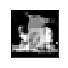

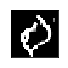

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 1.011759281158447e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -3.993199825286865e+00 1.0e+00 9.46e-01  9e-01  9e-01 0:00.0
    3     45 -2.855499275028706e-02 1.0e+00 9.27e-01  9e-01  9e-01 0:00.0
  100   1500 -2.306792831420898e+01 1.4e+00 8.71e-01  9e-01  9e-01 0:01.5
  200   3000 -3.200524520874023e+01 1.6e+00 7.71e-01  8e-01  8e-01 0:02.9
  300   4500 -3.447591018676758e+01 1.7e+00 6.11e-01  6e-01  6e-01 0:04.5
  400   6000 -3.583500671386719e+01 1.7e+00 4.45e-01  4e-01  5e-01 0:06.1
  500   7500 -3.702116394042969e+01 1.9e+00 4.60e-01  4e-01  5e-01 0:07.6


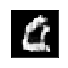

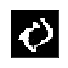

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -5.804831504821777e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -4.235600471496582e+00 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -7.919307708740234e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -3.036979293823242e+01 1.4e+00 7.47e-01  7e-01  8e-01 0:01.4
  200   3000 -3.616651916503906e+01 1.4e+00 5.66e-01  6e-01  6e-01 0:03.2
  300   4500 -3.754350280761719e+01 1.6e+00 5.02e-01  5e-01  5e-01 0:04.7
  400   6000 -3.807718276977539e+01 1.6e+00 3.01e-01  3e-01  3e-01 0:06.1
  500   7500 -4.042119598388672e+01 1.7e+00 2.53e-01  2e-01  3e-01 0:07.9


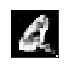

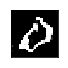

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -5.482496619224548e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.079952478408813e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -4.277247905731201e+00 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -2.769573402404785e+01 1.3e+00 8.07e-01  8e-01  8e-01 0:01.4
  200   3000 -3.396964263916016e+01 1.4e+00 6.56e-01  6e-01  7e-01 0:02.9
  300   4500 -3.638119125366211e+01 1.5e+00 5.48e-01  5e-01  6e-01 0:04.3
  400   6000 -3.807625961303711e+01 1.7e+00 4.46e-01  4e-01  5e-01 0:05.8
  500   7500 -3.808086395263672e+01 1.8e+00 3.64e-01  3e-01  4e-01 0:07.2


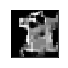

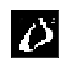

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -8.907936215400696e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -3.116035938262939e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -5.794689655303955e+00 1.0e+00 9.24e-01  9e-01  9e-01 0:00.0
  100   1500 -2.289159202575684e+01 1.3e+00 7.71e-01  8e-01  8e-01 0:01.6
  200   3000 -3.138113403320312e+01 1.4e+00 7.03e-01  7e-01  7e-01 0:03.1
  300   4500 -3.680506134033203e+01 1.5e+00 5.32e-01  5e-01  6e-01 0:04.5
  400   6000 -3.834907150268555e+01 1.6e+00 4.21e-01  4e-01  4e-01 0:06.1
  500   7500 -3.919006729125977e+01 1.6e+00 3.34e-01  3e-01  3e-01 0:07.8


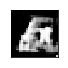

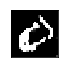

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.560589909553528e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -4.581805229187012e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -2.946540117263794e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -2.033680915832520e+01 1.3e+00 6.80e-01  7e-01  7e-01 0:01.5
  200   3000 -2.594859123229980e+01 1.5e+00 6.20e-01  6e-01  6e-01 0:02.9
  300   4500 -2.874405670166016e+01 1.6e+00 5.07e-01  5e-01  5e-01 0:04.4
  400   6000 -3.129975700378418e+01 1.7e+00 4.09e-01  4e-01  4e-01 0:05.9
  500   7500 -3.164355659484863e+01 1.8e+00 2.83e-01  3e-01  3e-01 0:07.3


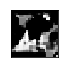

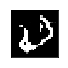

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.269933462142944e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -5.150406837463379e+00 1.0e+00 9.39e-01  9e-01  9e-01 0:00.0
    3     45 -5.703418254852295e+00 1.0e+00 9.16e-01  9e-01  9e-01 0:00.0
  100   1500 -3.293211746215820e+01 1.4e+00 7.20e-01  7e-01  7e-01 0:01.4
  200   3000 -3.733431625366211e+01 1.5e+00 5.29e-01  5e-01  5e-01 0:03.0
  300   4500 -3.885421752929688e+01 1.5e+00 3.36e-01  3e-01  3e-01 0:04.5
  400   6000 -4.021079254150391e+01 1.6e+00 2.77e-01  3e-01  3e-01 0:06.0
  500   7500 -4.200720214843750e+01 1.8e+00 2.17e-01  2e-01  2e-01 0:07.5


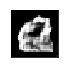

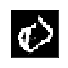

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.995529770851135e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -2.911490678787231e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -4.114055156707764e+00 1.0e+00 9.19e-01  9e-01  9e-01 0:00.0
  100   1500 -2.552724456787109e+01 1.3e+00 6.52e-01  6e-01  7e-01 0:01.5
  200   3000 -3.053349685668945e+01 1.5e+00 6.42e-01  6e-01  7e-01 0:03.1
  300   4500 -3.515030670166016e+01 1.6e+00 5.51e-01  5e-01  6e-01 0:04.9
  400   6000 -3.707261657714844e+01 1.6e+00 4.68e-01  4e-01  5e-01 0:06.5
  500   7500 -3.875098419189453e+01 1.7e+00 3.57e-01  3e-01  4e-01 0:07.9


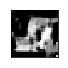

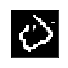

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.630202233791351e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -4.777245044708252e+00 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -3.126969099044800e+00 1.0e+00 9.25e-01  9e-01  9e-01 0:00.0
  100   1500 -3.022323989868164e+01 1.4e+00 7.85e-01  8e-01  8e-01 0:01.6
  200   3000 -3.469226074218750e+01 1.5e+00 6.86e-01  7e-01  7e-01 0:03.5
  300   4500 -3.552536773681641e+01 1.6e+00 5.93e-01  6e-01  6e-01 0:04.9
  400   6000 -4.031079483032227e+01 1.7e+00 4.48e-01  4e-01  5e-01 0:06.5
  500   7500 -4.044121170043945e+01 1.8e+00 3.81e-01  3e-01  4e-01 0:07.9


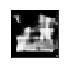

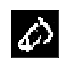

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.302138090133667e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -5.310813426971436e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -4.540731906890869e+00 1.0e+00 9.24e-01  9e-01  9e-01 0:00.0
  100   1500 -2.724881362915039e+01 1.3e+00 8.41e-01  8e-01  9e-01 0:01.5
  200   3000 -3.300586318969727e+01 1.5e+00 7.22e-01  7e-01  7e-01 0:03.0
  300   4500 -3.592024612426758e+01 1.7e+00 7.03e-01  6e-01  7e-01 0:04.4
  400   6000 -3.875274276733398e+01 1.8e+00 5.37e-01  5e-01  6e-01 0:05.8
  500   7500 -3.915836334228516e+01 1.8e+00 6.12e-01  5e-01  6e-01 0:07.3


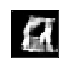

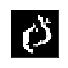

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.471426248550415e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -5.196456313133240e-01 1.0e+00 9.46e-01  9e-01  9e-01 0:00.0
    3     45 -2.309933423995972e+00 1.0e+00 9.26e-01  9e-01  9e-01 0:00.0
  100   1500 -2.955171203613281e+01 1.3e+00 7.11e-01  7e-01  7e-01 0:01.6
  200   3000 -3.566036987304688e+01 1.4e+00 5.12e-01  5e-01  5e-01 0:03.0
  300   4500 -3.855467605590820e+01 1.5e+00 3.13e-01  3e-01  3e-01 0:04.6
  400   6000 -3.968989562988281e+01 1.6e+00 2.77e-01  3e-01  3e-01 0:06.0
  500   7500 -4.035227203369141e+01 1.7e+00 2.04e-01  2e-01  2e-01 0:07.5


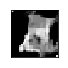

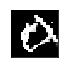

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -6.319990634918213e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -6.546032905578613e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -8.445713996887207e+00 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -3.067176628112793e+01 1.3e+00 7.30e-01  7e-01  7e-01 0:01.4
  200   3000 -3.435239791870117e+01 1.5e+00 5.35e-01  5e-01  5e-01 0:03.1
  300   4500 -3.662035751342773e+01 1.5e+00 3.77e-01  4e-01  4e-01 0:04.7
  400   6000 -3.836100769042969e+01 1.6e+00 2.64e-01  3e-01  3e-01 0:06.5
  500   7500 -3.953175354003906e+01 1.6e+00 1.82e-01  2e-01  2e-01 0:08.1


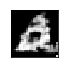

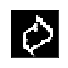

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -7.346486568450928e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -6.312095642089844e+00 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -7.101912498474121e+00 1.0e+00 9.24e-01  9e-01  9e-01 0:00.0
  100   1500 -2.898305130004883e+01 1.4e+00 7.64e-01  8e-01  8e-01 0:01.6
  200   3000 -3.405862426757812e+01 1.5e+00 7.16e-01  7e-01  7e-01 0:03.0
  300   4500 -3.661517333984375e+01 1.7e+00 6.19e-01  6e-01  6e-01 0:04.4
  400   6000 -3.914710617065430e+01 1.9e+00 5.93e-01  6e-01  6e-01 0:06.0
  500   7500 -3.936375427246094e+01 2.0e+00 6.05e-01  6e-01  7e-01 0:07.4


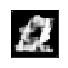

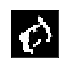

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.997474193572998e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -2.885152816772461e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -8.450742721557617e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -2.975729370117188e+01 1.3e+00 7.58e-01  7e-01  8e-01 0:01.4
  200   3000 -3.728830337524414e+01 1.5e+00 6.13e-01  6e-01  6e-01 0:03.0
  300   4500 -3.936422729492188e+01 1.5e+00 4.17e-01  4e-01  4e-01 0:04.5
  400   6000 -4.064501953125000e+01 1.6e+00 2.87e-01  3e-01  3e-01 0:06.1
  500   7500 -4.247515487670898e+01 1.7e+00 2.57e-01  2e-01  3e-01 0:07.6


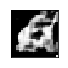

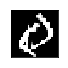

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.128038406372070e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -9.820763468742371e-01 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -1.790132522583008e+00 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -2.330175399780273e+01 1.4e+00 8.36e-01  8e-01  8e-01 0:01.5
  200   3000 -2.907500267028809e+01 1.5e+00 7.71e-01  7e-01  8e-01 0:02.9
  300   4500 -3.325989532470703e+01 1.6e+00 5.81e-01  5e-01  6e-01 0:04.4
  400   6000 -3.519131851196289e+01 1.7e+00 4.40e-01  4e-01  5e-01 0:05.8
  500   7500 -3.675746154785156e+01 1.8e+00 3.75e-01  3e-01  4e-01 0:07.3


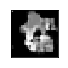

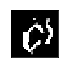

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.651096463203430e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -9.744153618812561e-01 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -2.390398263931274e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -3.284875106811523e+01 1.3e+00 7.00e-01  7e-01  7e-01 0:01.4
  200   3000 -3.570781707763672e+01 1.5e+00 5.72e-01  6e-01  6e-01 0:03.3
  300   4500 -3.906986618041992e+01 1.7e+00 4.28e-01  4e-01  4e-01 0:05.0
  400   6000 -3.964395904541016e+01 1.7e+00 2.96e-01  3e-01  3e-01 0:06.5
  500   7500 -4.054900741577148e+01 1.7e+00 1.95e-01  2e-01  2e-01 0:08.0


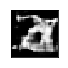

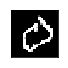

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -7.504732131958008e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -6.242115020751953e+00 1.0e+00 9.46e-01  9e-01  9e-01 0:00.0
    3     45 -5.183314323425293e+00 1.0e+00 9.26e-01  9e-01  9e-01 0:00.0
  100   1500 -3.164762306213379e+01 1.4e+00 7.28e-01  7e-01  7e-01 0:01.5
  200   3000 -3.522840499877930e+01 1.5e+00 4.62e-01  4e-01  5e-01 0:02.9
  300   4500 -3.851938629150391e+01 1.6e+00 3.91e-01  4e-01  4e-01 0:04.5
  400   6000 -4.032305526733398e+01 1.7e+00 3.13e-01  3e-01  3e-01 0:06.0
  500   7500 -4.159260940551758e+01 1.7e+00 1.97e-01  2e-01  2e-01 0:07.7


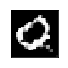

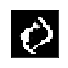

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.853322029113770e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -3.779501199722290e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -3.994710922241211e+00 1.0e+00 9.24e-01  9e-01  9e-01 0:00.0
  100   1500 -3.036139106750488e+01 1.3e+00 7.40e-01  7e-01  7e-01 0:01.5
  200   3000 -3.510460281372070e+01 1.4e+00 5.16e-01  5e-01  5e-01 0:03.0
  300   4500 -4.021431350708008e+01 1.6e+00 4.10e-01  4e-01  4e-01 0:04.4
  400   6000 -4.185855865478516e+01 1.7e+00 3.30e-01  3e-01  3e-01 0:06.1
  500   7500 -4.260559082031250e+01 1.8e+00 2.69e-01  2e-01  3e-01 0:08.2


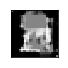

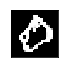

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.647171735763550e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -3.617328166961670e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -6.811341762542725e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.1
  100   1500 -3.077795028686523e+01 1.3e+00 7.70e-01  8e-01  8e-01 0:01.5
  200   3000 -3.321515655517578e+01 1.5e+00 6.43e-01  6e-01  7e-01 0:03.0
  300   4500 -3.575119400024414e+01 1.5e+00 4.93e-01  5e-01  5e-01 0:04.5
  400   6000 -3.779861831665039e+01 1.5e+00 4.31e-01  4e-01  4e-01 0:05.9
  500   7500 -3.947611236572266e+01 1.6e+00 4.10e-01  4e-01  4e-01 0:07.4


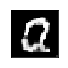

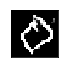

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.741529226303101e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -1.225772142410278e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -8.274199485778809e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -3.293770217895508e+01 1.3e+00 7.58e-01  7e-01  8e-01 0:01.4
  200   3000 -3.547233581542969e+01 1.5e+00 6.48e-01  6e-01  7e-01 0:02.9
  300   4500 -3.783629226684570e+01 1.5e+00 4.60e-01  4e-01  5e-01 0:04.3
  400   6000 -4.075091552734375e+01 1.6e+00 3.46e-01  3e-01  4e-01 0:05.8
  500   7500 -4.125954055786133e+01 1.7e+00 2.16e-01  2e-01  2e-01 0:07.2


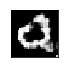

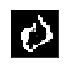

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -9.700921773910522e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.525561451911926e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -8.359326720237732e-01 1.0e+00 9.19e-01  9e-01  9e-01 0:00.0
  100   1500 -3.170933914184570e+01 1.3e+00 6.41e-01  6e-01  6e-01 0:01.4
  200   3000 -3.626157760620117e+01 1.4e+00 5.08e-01  5e-01  5e-01 0:02.9
  300   4500 -3.815946197509766e+01 1.6e+00 4.00e-01  4e-01  4e-01 0:04.4
  400   6000 -4.002098464965820e+01 1.6e+00 3.25e-01  3e-01  3e-01 0:05.9
  500   7500 -4.029129409790039e+01 1.7e+00 2.79e-01  3e-01  3e-01 0:07.5


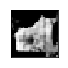

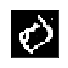

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -4.197404861450195e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -5.002087116241455e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -3.662744522094727e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -2.889898681640625e+01 1.4e+00 7.51e-01  7e-01  8e-01 0:01.5
  200   3000 -3.215843200683594e+01 1.5e+00 5.65e-01  5e-01  6e-01 0:03.0
  300   4500 -3.571511840820312e+01 1.6e+00 4.71e-01  4e-01  5e-01 0:04.5
  400   6000 -3.692572402954102e+01 1.7e+00 3.39e-01  3e-01  3e-01 0:06.0
  500   7500 -3.736240768432617e+01 1.8e+00 2.40e-01  2e-01  3e-01 0:07.4


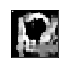

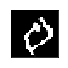

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -4.716550707817078e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -9.660884141921997e-01 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -8.326259255409241e-02 1.0e+00 9.24e-01  9e-01  9e-01 0:00.0
WARNING (module=cma.utilities.utils, iteration=13):  flat fitness (sigma=8.42e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=13):  flat fitness (sigma=8.42e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=20):  flat fitness (sigma=8.26e-01).
                    For small sigma, this could indicate numerical convergence.
                    Ot

WARNING (module=cma.utilities.utils, iteration=35):  flat fitness (sigma=8.51e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=35):  flat fitness (sigma=8.51e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=36):  flat fitness (sigma=8.52e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=36):  flat fitness (sigma=8.52e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=56):  flat fitness (sigma=8.83e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=56):  flat fitness (sigma=8.83e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=57):  flat fitness (sigma=8.88e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=57):  flat fitness (sigma=8.88e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=72):  flat fitness (sigma=9.26e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=72):  flat fitness (sigma=9.26e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=73):  flat fitness (sigma=9.28e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=73):  flat fitness (sigma=9.28e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=88):  flat fitness (sigma=9.82e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=88):  flat fitness (sigma=9.82e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=89):  flat fitness (sigma=9.86e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=89):  flat fitness (sigma=9.86e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=104):  flat fitness (sigma=1.05e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=104):  flat fitness (sigma=1.05e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=105):  flat fitness (sigma=1.05e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=105):  flat fitness (sigma=1.05e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=120):  flat fitness (sigma=1.11e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=120):  flat fitness (sigma=1.11e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=121):  flat fitness (sigma=1.10e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=121):  flat fitness (sigma=1.10e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=136):  flat fitness (sigma=1.10e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=137):  flat fitness (sigma=1.10e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=137):  flat fitness (sigma=1.10e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=138):  flat fitness (sigma=1.09e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=156):  flat fitness (sigma=1.06e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=156):  flat fitness (sigma=1.06e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=157):  flat fitness (sigma=1.06e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=157):  flat fitness (sigma=1.06e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=180):  flat fitness (sigma=1.04e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=180):  flat fitness (sigma=1.04e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=181):  flat fitness (sigma=1.04e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=181):  flat fitness (sigma=1.04e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=196):  flat fitness (sigma=1.06e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=196):  flat fitness (sigma=1.06e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=197):  flat fitness (sigma=1.07e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=197):  flat fitness (sigma=1.07e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=215):  flat fitness (sigma=1.11e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=215):  flat fitness (sigma=1.11e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=217):  flat fitness (sigma=1.10e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=217):  flat fitness (sigma=1.10e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=235):  flat fitness (sigma=1.02e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=235):  flat fitness (sigma=1.02e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=236):  flat fitness (sigma=1.02e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=236):  flat fitness (sigma=1.02e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=251):  flat fitness (sigma=1.07e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=251):  flat fitness (sigma=1.07e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=252):  flat fitness (sigma=1.08e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=252):  flat fitness (sigma=1.08e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=270):  flat fitness (sigma=1.12e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=270):  flat fitness (sigma=1.12e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=271):  flat fitness (sigma=1.12e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=271):  flat fitness (sigma=1.12e+00).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

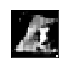

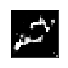

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.331145048141479e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -3.471505403518677e+00 1.0e+00 9.40e-01  9e-01  9e-01 0:00.0
    3     45 -6.874859929084778e-01 1.0e+00 9.17e-01  9e-01  9e-01 0:00.0
  100   1500 -3.175826263427734e+01 1.3e+00 8.19e-01  8e-01  8e-01 0:01.6
  200   3000 -3.626656723022461e+01 1.5e+00 6.77e-01  6e-01  7e-01 0:03.0
  300   4500 -3.840605163574219e+01 1.7e+00 5.68e-01  5e-01  6e-01 0:04.8
  400   6000 -3.966266250610352e+01 1.8e+00 4.96e-01  4e-01  5e-01 0:06.3
  500   7500 -4.026044464111328e+01 2.0e+00 4.20e-01  4e-01  4e-01 0:07.8


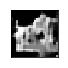

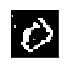

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -4.816766262054443e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -2.538461923599243e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -2.261794805526733e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -2.741015625000000e+01 1.4e+00 7.97e-01  8e-01  8e-01 0:01.4
  200   3000 -3.406761550903320e+01 1.4e+00 6.09e-01  6e-01  6e-01 0:02.9
  300   4500 -3.806214904785156e+01 1.5e+00 5.09e-01  5e-01  5e-01 0:04.3
  400   6000 -4.012974929809570e+01 1.6e+00 3.70e-01  4e-01  4e-01 0:05.9
  500   7500 -4.126532363891602e+01 1.7e+00 2.65e-01  2e-01  3e-01 0:07.4


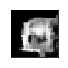

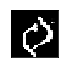

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.239726424217224e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -4.631068930029869e-02 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -1.900085657835007e-01 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -1.510308456420898e+01 1.3e+00 7.93e-01  8e-01  8e-01 0:01.4
  200   3000 -2.360517120361328e+01 1.6e+00 7.51e-01  7e-01  8e-01 0:02.9
  300   4500 -2.562251663208008e+01 1.8e+00 5.72e-01  5e-01  6e-01 0:04.4
  400   6000 -2.809364509582520e+01 1.9e+00 4.96e-01  5e-01  5e-01 0:05.9
  500   7500 -2.999954605102539e+01 2.0e+00 4.00e-01  4e-01  4e-01 0:07.3


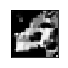

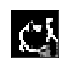

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.907226324081421e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -5.530850887298584e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -1.556398987770081e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -2.771030235290527e+01 1.3e+00 6.39e-01  6e-01  6e-01 0:01.4
  200   3000 -3.317749404907227e+01 1.4e+00 4.44e-01  4e-01  5e-01 0:03.0
  300   4500 -3.465244674682617e+01 1.5e+00 3.44e-01  3e-01  3e-01 0:04.4
  400   6000 -3.627638244628906e+01 1.6e+00 2.76e-01  3e-01  3e-01 0:06.0
  500   7500 -3.766969299316406e+01 1.6e+00 2.00e-01  2e-01  2e-01 0:07.5


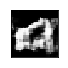

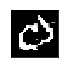

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.598869800567627e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -2.991688728332520e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -6.396155357360840e+00 1.0e+00 9.19e-01  9e-01  9e-01 0:00.0
  100   1500 -2.910875320434570e+01 1.3e+00 6.38e-01  6e-01  6e-01 0:01.5
  200   3000 -3.283345413208008e+01 1.5e+00 5.87e-01  6e-01  6e-01 0:03.2
  300   4500 -3.667045974731445e+01 1.6e+00 4.62e-01  4e-01  5e-01 0:04.9
  400   6000 -3.963446807861328e+01 1.6e+00 3.51e-01  3e-01  4e-01 0:06.5
  500   7500 -4.085578536987305e+01 1.7e+00 2.74e-01  2e-01  3e-01 0:08.0


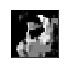

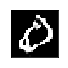

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -4.631068930029869e-02 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -3.458259105682373e-01 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -3.431296348571777e+00 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -2.512883758544922e+01 1.3e+00 7.56e-01  7e-01  8e-01 0:01.5
  200   3000 -2.879294013977051e+01 1.6e+00 8.00e-01  8e-01  8e-01 0:03.0
  300   4500 -3.366219711303711e+01 1.6e+00 7.03e-01  7e-01  7e-01 0:04.6
  400   6000 -3.483985900878906e+01 1.7e+00 5.14e-01  5e-01  5e-01 0:06.1
  500   7500 -3.615750503540039e+01 1.7e+00 4.04e-01  4e-01  4e-01 0:07.6


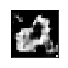

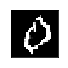

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.160315275192261e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -7.012209892272949e+00 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -4.973807334899902e+00 1.0e+00 9.24e-01  9e-01  9e-01 0:00.0
  100   1500 -3.301190185546875e+01 1.3e+00 6.42e-01  6e-01  7e-01 0:01.4
  200   3000 -3.521180343627930e+01 1.5e+00 5.23e-01  5e-01  5e-01 0:03.2
  300   4500 -3.815342330932617e+01 1.6e+00 3.89e-01  4e-01  4e-01 0:04.8
  400   6000 -3.922309112548828e+01 1.7e+00 3.00e-01  3e-01  3e-01 0:06.3
  500   7500 -3.993889236450195e+01 1.7e+00 2.44e-01  2e-01  3e-01 0:07.9


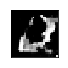

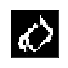

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -8.107222318649292e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -1.105865836143494e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -2.026486158370972e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -2.386496162414551e+01 1.3e+00 6.60e-01  6e-01  7e-01 0:01.4
  200   3000 -2.977327919006348e+01 1.4e+00 5.54e-01  5e-01  6e-01 0:02.9
  300   4500 -3.351816177368164e+01 1.5e+00 4.27e-01  4e-01  4e-01 0:04.5
  400   6000 -3.684016799926758e+01 1.6e+00 3.47e-01  3e-01  4e-01 0:06.0
  500   7500 -3.879766464233398e+01 1.7e+00 2.97e-01  3e-01  3e-01 0:07.5


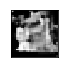

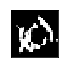

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.723028182983398e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -6.978149890899658e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -4.212976455688477e+00 1.0e+00 9.19e-01  9e-01  9e-01 0:00.0
  100   1500 -2.976363372802734e+01 1.4e+00 7.33e-01  7e-01  7e-01 0:01.5
  200   3000 -3.324019241333008e+01 1.5e+00 6.14e-01  6e-01  6e-01 0:03.2
  300   4500 -3.681224822998047e+01 1.5e+00 4.82e-01  4e-01  5e-01 0:04.6
  400   6000 -3.832464599609375e+01 1.7e+00 3.27e-01  3e-01  3e-01 0:06.1
  500   7500 -3.929866409301758e+01 1.8e+00 2.52e-01  2e-01  3e-01 0:07.5


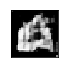

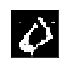

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -5.482302665710449e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -1.527918696403503e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -8.142102241516113e+00 1.0e+00 9.19e-01  9e-01  9e-01 0:00.0
  100   1500 -2.809676361083984e+01 1.4e+00 9.07e-01  9e-01  9e-01 0:01.8
  200   3000 -3.577072525024414e+01 1.4e+00 5.50e-01  5e-01  6e-01 0:03.7
  300   4500 -3.818784713745117e+01 1.5e+00 3.95e-01  4e-01  4e-01 0:05.6
  400   6000 -3.970627212524414e+01 1.5e+00 3.23e-01  3e-01  3e-01 0:07.1
  500   7500 -4.110577011108398e+01 1.6e+00 2.75e-01  3e-01  3e-01 0:08.5


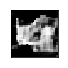

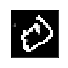

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 1.135468006134033e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -3.908293724060059e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -1.893643140792847e-01 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -1.749868243932724e-01 1.3e+00 8.33e-01  8e-01  8e-01 0:01.4
  200   3000 -2.187354564666748e-01 1.5e+00 7.16e-01  7e-01  7e-01 0:02.9
  300   4500 -2.219026535749435e-01 1.6e+00 6.86e-01  7e-01  7e-01 0:04.4
  400   6000 -2.299519777297974e-01 1.6e+00 6.47e-01  6e-01  7e-01 0:05.9
  500   7500 -3.007907271385193e-01 1.6e+00 5.98e-01  6e-01  6e-01 0:07.3


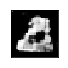

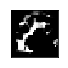

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.602488040924072e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -4.631068930029869e-02 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -6.996935606002808e-01 1.0e+00 9.25e-01  9e-01  9e-01 0:00.0
  100   1500 -2.458183479309082e+01 1.3e+00 7.25e-01  7e-01  7e-01 0:01.4
  200   3000 -3.332971572875977e+01 1.5e+00 6.83e-01  6e-01  7e-01 0:02.9
  300   4500 -3.797113037109375e+01 1.6e+00 5.96e-01  5e-01  6e-01 0:04.3
  400   6000 -3.939488601684570e+01 1.7e+00 4.37e-01  4e-01  4e-01 0:05.9
  500   7500 -4.120313262939453e+01 1.8e+00 3.22e-01  3e-01  3e-01 0:07.4


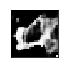

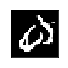

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -6.462400436401367e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.950065374374390e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -2.666217327117920e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -2.949726676940918e+01 1.3e+00 6.40e-01  6e-01  7e-01 0:01.6
  200   3000 -3.475424957275391e+01 1.4e+00 4.47e-01  4e-01  5e-01 0:03.5
  300   4500 -3.618738937377930e+01 1.5e+00 3.61e-01  3e-01  4e-01 0:04.9
  400   6000 -3.858359909057617e+01 1.6e+00 3.07e-01  3e-01  3e-01 0:06.5
  500   7500 -3.956674575805664e+01 1.7e+00 2.75e-01  2e-01  3e-01 0:08.5


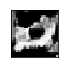

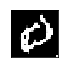

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.582340121269226e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.419302463531494e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -2.106172084808350e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -2.277395820617676e+01 1.3e+00 7.18e-01  7e-01  7e-01 0:01.4
  200   3000 -2.558764839172363e+01 1.5e+00 4.81e-01  5e-01  5e-01 0:03.2
  300   4500 -2.822157287597656e+01 1.6e+00 3.66e-01  3e-01  4e-01 0:04.9
  400   6000 -3.005150413513184e+01 1.7e+00 2.74e-01  3e-01  3e-01 0:06.5
  500   7500 -3.111916351318359e+01 1.8e+00 2.10e-01  2e-01  2e-01 0:08.1


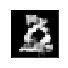

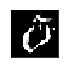

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -7.739438533782959e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.789240837097168e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -4.078608036041260e+00 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -3.096734428405762e+01 1.4e+00 7.32e-01  7e-01  7e-01 0:01.7
  200   3000 -3.649699783325195e+01 1.5e+00 5.82e-01  6e-01  6e-01 0:03.4
  300   4500 -4.001209259033203e+01 1.6e+00 4.11e-01  4e-01  4e-01 0:04.9
  400   6000 -4.089441299438477e+01 1.7e+00 3.23e-01  3e-01  3e-01 0:06.3
  500   7500 -4.103824234008789e+01 1.7e+00 2.70e-01  3e-01  3e-01 0:07.9


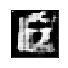

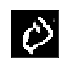

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.575813531875610e-01 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -6.244777679443359e+00 1.0e+00 9.46e-01  9e-01  9e-01 0:00.0
    3     45 -1.286816477775574e+00 1.0e+00 9.27e-01  9e-01  9e-01 0:00.0
  100   1500 -2.265313529968262e+01 1.3e+00 6.79e-01  7e-01  7e-01 0:01.4
  200   3000 -3.105383682250977e+01 1.5e+00 6.26e-01  6e-01  6e-01 0:02.9
  300   4500 -3.369068527221680e+01 1.6e+00 5.35e-01  5e-01  6e-01 0:04.4
  400   6000 -3.684193038940430e+01 1.6e+00 4.18e-01  4e-01  4e-01 0:05.8
  500   7500 -3.783969879150391e+01 1.7e+00 3.75e-01  3e-01  4e-01 0:07.4


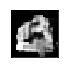

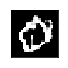

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.778708219528198e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.207645177841187e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -6.207225799560547e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -2.916520881652832e+01 1.3e+00 7.04e-01  7e-01  7e-01 0:01.5
  200   3000 -3.470322036743164e+01 1.5e+00 5.74e-01  6e-01  6e-01 0:03.1
  300   4500 -3.653212738037109e+01 1.5e+00 3.81e-01  4e-01  4e-01 0:04.7
  400   6000 -3.787551116943359e+01 1.5e+00 3.54e-01  3e-01  4e-01 0:06.2
  500   7500 -3.967401123046875e+01 1.6e+00 2.68e-01  3e-01  3e-01 0:07.7


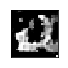

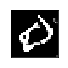

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 1.550904214382172e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -2.002811670303345e+00 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -4.098801612854004e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -2.603162193298340e+01 1.3e+00 7.43e-01  7e-01  8e-01 0:01.4
  200   3000 -3.473625564575195e+01 1.5e+00 5.40e-01  5e-01  6e-01 0:02.9
  300   4500 -3.840159225463867e+01 1.5e+00 4.18e-01  4e-01  4e-01 0:04.3
  400   6000 -4.015977478027344e+01 1.6e+00 2.76e-01  3e-01  3e-01 0:05.9
  500   7500 -4.098175811767578e+01 1.7e+00 2.21e-01  2e-01  2e-01 0:07.4


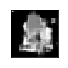

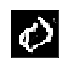

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.291981220245361e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -5.983736038208008e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -2.953174114227295e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -3.134842681884766e+01 1.3e+00 5.87e-01  6e-01  6e-01 0:01.6
  200   3000 -3.434920501708984e+01 1.4e+00 4.04e-01  4e-01  4e-01 0:03.2
  300   4500 -3.690098190307617e+01 1.5e+00 2.94e-01  3e-01  3e-01 0:04.8
  400   6000 -3.829178237915039e+01 1.6e+00 2.14e-01  2e-01  2e-01 0:06.2
  500   7500 -3.898562622070312e+01 1.7e+00 1.64e-01  1e-01  2e-01 0:07.7


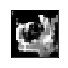

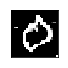

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -6.574876308441162e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -4.391384124755859e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -7.256380081176758e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -3.082568359375000e+01 1.3e+00 7.09e-01  7e-01  7e-01 0:01.7
  200   3000 -3.488752365112305e+01 1.5e+00 5.49e-01  5e-01  6e-01 0:03.2
  300   4500 -3.600839233398438e+01 1.6e+00 4.48e-01  4e-01  5e-01 0:04.6
  400   6000 -3.783445739746094e+01 1.7e+00 2.94e-01  3e-01  3e-01 0:06.1
  500   7500 -3.827693176269531e+01 1.7e+00 2.26e-01  2e-01  2e-01 0:07.5


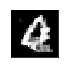

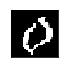

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.514892339706421e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -3.521706819534302e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -4.432632446289062e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -3.141118049621582e+01 1.3e+00 6.73e-01  7e-01  7e-01 0:01.4
  200   3000 -3.957275009155273e+01 1.6e+00 6.43e-01  6e-01  7e-01 0:02.9
  300   4500 -4.181684112548828e+01 1.7e+00 3.91e-01  4e-01  4e-01 0:04.4
  400   6000 -4.290761184692383e+01 1.7e+00 3.37e-01  3e-01  4e-01 0:05.9
  500   7500 -4.419907379150391e+01 1.8e+00 2.32e-01  2e-01  2e-01 0:07.4


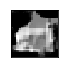

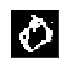

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.750342488288879e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -6.707514524459839e-01 1.0e+00 9.40e-01  9e-01  9e-01 0:00.0
    3     45 -7.752994298934937e-01 1.0e+00 9.17e-01  9e-01  9e-01 0:00.0
  100   1500 -2.267064857482910e+01 1.4e+00 7.64e-01  8e-01  8e-01 0:01.5
  200   3000 -3.198160552978516e+01 1.5e+00 8.37e-01  8e-01  9e-01 0:03.0
  300   4500 -3.671800231933594e+01 1.6e+00 7.55e-01  7e-01  8e-01 0:04.4
  400   6000 -3.792631912231445e+01 1.7e+00 6.91e-01  7e-01  7e-01 0:05.9
  500   7500 -4.027823638916016e+01 1.7e+00 5.33e-01  5e-01  6e-01 0:07.9


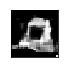

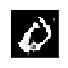

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 3.514632284641266e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 2.258594334125519e-01 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -2.346126139163971e-01 1.0e+00 9.27e-01  9e-01  9e-01 0:00.0
  100   1500 -2.705463790893555e+01 1.3e+00 9.03e-01  9e-01  9e-01 0:01.4
  200   3000 -3.446919250488281e+01 1.6e+00 7.70e-01  7e-01  8e-01 0:02.9
  300   4500 -3.808499908447266e+01 1.6e+00 5.12e-01  5e-01  5e-01 0:05.0
  400   6000 -3.938168716430664e+01 1.8e+00 4.11e-01  4e-01  4e-01 0:06.9
  500   7500 -3.952761459350586e+01 1.9e+00 3.69e-01  3e-01  4e-01 0:08.7


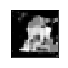

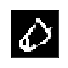

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.830936193466187e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -4.675735473632812e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -4.731714248657227e+00 1.0e+00 9.18e-01  9e-01  9e-01 0:00.0
  100   1500 -3.097466087341309e+01 1.3e+00 8.28e-01  8e-01  8e-01 0:01.5
  200   3000 -3.517118835449219e+01 1.5e+00 5.65e-01  6e-01  6e-01 0:03.0
  300   4500 -3.769904327392578e+01 1.6e+00 4.45e-01  4e-01  5e-01 0:04.6
  400   6000 -3.840780258178711e+01 1.6e+00 3.53e-01  3e-01  4e-01 0:06.1
  500   7500 -3.894546890258789e+01 1.7e+00 2.15e-01  2e-01  2e-01 0:07.6


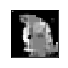

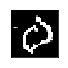

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -6.489038467407227e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -2.976984500885010e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -5.746986865997314e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -2.228119468688965e+01 1.4e+00 8.14e-01  8e-01  8e-01 0:01.4
  200   3000 -2.759954261779785e+01 1.6e+00 8.33e-01  8e-01  9e-01 0:02.9
  300   4500 -2.823229026794434e+01 1.7e+00 6.46e-01  6e-01  7e-01 0:04.3
  400   6000 -3.114176368713379e+01 1.8e+00 4.62e-01  4e-01  5e-01 0:05.8
  500   7500 -3.283665847778320e+01 1.8e+00 3.93e-01  4e-01  4e-01 0:07.2


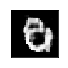

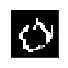

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -4.799294948577881e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -8.658506274223328e-01 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -5.256776809692383e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -2.834597396850586e+01 1.3e+00 5.79e-01  6e-01  6e-01 0:01.6
  200   3000 -3.399069213867188e+01 1.4e+00 4.26e-01  4e-01  4e-01 0:03.1
  300   4500 -3.636547851562500e+01 1.5e+00 2.95e-01  3e-01  3e-01 0:04.6
  400   6000 -3.911003875732422e+01 1.5e+00 2.07e-01  2e-01  2e-01 0:06.0
  500   7500 -4.076941680908203e+01 1.6e+00 1.65e-01  2e-01  2e-01 0:07.8


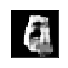

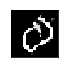

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.391962870955467e-02 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.771577596664429e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -2.277877092361450e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -4.168483734130859e+00 1.3e+00 6.62e-01  7e-01  7e-01 0:01.7
  200   3000 -9.350723266601562e+00 1.4e+00 6.60e-01  6e-01  7e-01 0:03.2
  300   4500 -1.220257091522217e+01 1.5e+00 5.90e-01  6e-01  6e-01 0:04.8
  400   6000 -1.300584506988525e+01 1.5e+00 4.80e-01  4e-01  5e-01 0:06.2
  500   7500 -1.402537918090820e+01 1.6e+00 4.43e-01  4e-01  5e-01 0:07.9


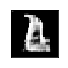

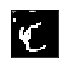

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -5.444335341453552e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -9.815550446510315e-01 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -7.146438956260681e-02 1.0e+00 9.25e-01  9e-01  9e-01 0:00.0
  100   1500 -2.318462181091309e+01 1.3e+00 9.01e-01  9e-01  9e-01 0:01.4
  200   3000 -2.682644653320312e+01 1.5e+00 8.19e-01  8e-01  8e-01 0:02.9
  300   4500 -3.267218399047852e+01 1.5e+00 8.46e-01  8e-01  9e-01 0:04.5
  400   6000 -3.429605102539062e+01 1.7e+00 7.52e-01  7e-01  8e-01 0:05.9
  500   7500 -3.567961502075195e+01 1.8e+00 6.82e-01  6e-01  7e-01 0:07.3


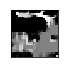

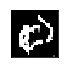

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.062042236328125e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -1.755607724189758e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -2.523359537124634e+00 1.0e+00 9.17e-01  9e-01  9e-01 0:00.0
  100   1500 -2.792134857177734e+01 1.3e+00 6.56e-01  6e-01  7e-01 0:01.5
  200   3000 -3.445096588134766e+01 1.5e+00 4.88e-01  5e-01  5e-01 0:03.0
  300   4500 -3.672116088867188e+01 1.5e+00 3.77e-01  4e-01  4e-01 0:04.4
  400   6000 -3.785482025146484e+01 1.5e+00 2.58e-01  2e-01  3e-01 0:05.8
  500   7500 -3.851905441284180e+01 1.6e+00 2.10e-01  2e-01  2e-01 0:07.6


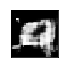

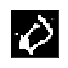

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -8.575451850891113e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -1.593219757080078e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -8.461487293243408e-01 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -2.226183319091797e+01 1.3e+00 6.56e-01  6e-01  7e-01 0:01.4
  200   3000 -2.707135200500488e+01 1.4e+00 5.91e-01  6e-01  6e-01 0:02.9
  300   4500 -2.976242637634277e+01 1.5e+00 4.55e-01  4e-01  5e-01 0:04.4
  400   6000 -3.203774261474609e+01 1.6e+00 4.47e-01  4e-01  5e-01 0:06.0
  500   7500 -3.356789779663086e+01 1.6e+00 3.87e-01  4e-01  4e-01 0:07.5


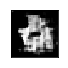

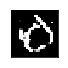

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 7.793359756469727e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -1.089514642953873e-01 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -1.354788839817047e-01 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -3.063105964660645e+01 1.3e+00 6.08e-01  6e-01  6e-01 0:01.5
  200   3000 -3.803871917724609e+01 1.5e+00 5.53e-01  5e-01  6e-01 0:03.0
  300   4500 -3.952118301391602e+01 1.8e+00 5.17e-01  5e-01  5e-01 0:04.5
  400   6000 -3.998321533203125e+01 1.8e+00 4.57e-01  4e-01  5e-01 0:06.0
  500   7500 -4.105957412719727e+01 1.9e+00 3.04e-01  3e-01  3e-01 0:07.6


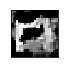

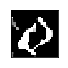

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.087592363357544e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -8.602347970008850e-01 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -3.056100845336914e+00 1.0e+00 9.20e-01  9e-01  9e-01 0:00.0
  100   1500 -2.619326591491699e+01 1.4e+00 8.33e-01  8e-01  9e-01 0:01.4
  200   3000 -3.473540496826172e+01 1.5e+00 7.02e-01  7e-01  7e-01 0:03.0
  300   4500 -3.720835494995117e+01 1.6e+00 5.17e-01  5e-01  5e-01 0:04.7
  400   6000 -3.894661712646484e+01 1.7e+00 4.02e-01  4e-01  4e-01 0:06.1
  500   7500 -3.942051696777344e+01 1.8e+00 3.61e-01  3e-01  4e-01 0:07.5


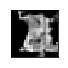

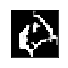

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -7.014016509056091e-01 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.973366379737854e-01 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -2.598557233810425e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -3.082998275756836e+01 1.4e+00 8.51e-01  8e-01  9e-01 0:01.5
  200   3000 -3.585329818725586e+01 1.5e+00 5.88e-01  6e-01  6e-01 0:02.9
  300   4500 -3.715888595581055e+01 1.6e+00 4.64e-01  4e-01  5e-01 0:04.4
  400   6000 -3.958352661132812e+01 1.7e+00 3.73e-01  3e-01  4e-01 0:06.0
  500   7500 -4.090705871582031e+01 1.7e+00 2.38e-01  2e-01  2e-01 0:07.4


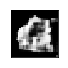

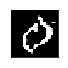

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -9.754362106323242e-01 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -9.748285412788391e-01 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -9.833303093910217e-02 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
WARNING (module=cma.utilities.utils, iteration=14):  flat fitness (sigma=8.10e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=14):  flat fitness (sigma=8.10e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=20):  flat fitness (sigma=7.71e-01).
                    For small sigma, this could indicate numerical convergence.
                    Ot

WARNING (module=cma.utilities.utils, iteration=39):  flat fitness (sigma=7.12e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=39):  flat fitness (sigma=7.12e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=40):  flat fitness (sigma=7.08e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=40):  flat fitness (sigma=7.08e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=55):  flat fitness (sigma=6.74e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=55):  flat fitness (sigma=6.74e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=56):  flat fitness (sigma=6.75e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=56):  flat fitness (sigma=6.75e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=78):  flat fitness (sigma=7.02e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=78):  flat fitness (sigma=7.02e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=79):  flat fitness (sigma=7.03e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=79):  flat fitness (sigma=7.03e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=94):  flat fitness (sigma=7.25e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=94):  flat fitness (sigma=7.25e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=95):  flat fitness (sigma=7.25e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=95):  flat fitness (sigma=7.25e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=115):  flat fitness (sigma=7.27e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=115):  flat fitness (sigma=7.27e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=116):  flat fitness (sigma=7.30e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=116):  flat fitness (sigma=7.30e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=131):  flat fitness (sigma=7.43e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=131):  flat fitness (sigma=7.43e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=132):  flat fitness (sigma=7.43e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=132):  flat fitness (sigma=7.43e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=147):  flat fitness (sigma=7.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=147):  flat fitness (sigma=7.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=148):  flat fitness (sigma=7.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=148):  flat fitness (sigma=7.70e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=163):  flat fitness (sigma=7.87e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=163):  flat fitness (sigma=7.87e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=164):  flat fitness (sigma=7.88e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=164):  flat fitness (sigma=7.88e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=179):  flat fitness (sigma=8.29e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=179):  flat fitness (sigma=8.29e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=180):  flat fitness (sigma=8.33e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=180):  flat fitness (sigma=8.33e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=200):  flat fitness (sigma=8.35e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=201):  flat fitness (sigma=8.36e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=201):  flat fitness (sigma=8.36e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=202):  flat fitness (sigma=8.38e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=217):  flat fitness (sigma=8.44e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=217):  flat fitness (sigma=8.44e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=218):  flat fitness (sigma=8.40e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=218):  flat fitness (sigma=8.40e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=239):  flat fitness (sigma=8.28e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=239):  flat fitness (sigma=8.28e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=240):  flat fitness (sigma=8.29e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=240):  flat fitness (sigma=8.29e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=255):  flat fitness (sigma=8.14e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=255):  flat fitness (sigma=8.14e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=256):  flat fitness (sigma=8.14e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=256):  flat fitness (sigma=8.14e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=271):  flat fitness (sigma=7.94e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=271):  flat fitness (sigma=7.94e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=272):  flat fitness (sigma=7.92e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
  272   4080 -4.631068930029869e-02 1.5e+00 7.92e-01  8e-01  8e-01 0:04.0
WARNING (module=cma.utilities.utils, iteration=272):  flat fitness (sigma=7.92e-01).
                    For small sigma, this could indicate n

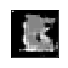

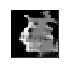

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.791538953781128e+00 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 1.133146584033966e-01 1.0e+00 9.47e-01  9e-01  9e-01 0:00.0
    3     45 -1.298304945230484e-01 1.0e+00 9.27e-01  9e-01  9e-01 0:00.0
  100   1500 -1.605878448486328e+01 1.3e+00 6.72e-01  7e-01  7e-01 0:01.5
  200   3000 -2.060336494445801e+01 1.5e+00 6.23e-01  6e-01  6e-01 0:03.0
  300   4500 -2.566398811340332e+01 1.6e+00 5.64e-01  5e-01  6e-01 0:04.4
  400   6000 -2.912469863891602e+01 1.7e+00 5.16e-01  5e-01  5e-01 0:05.9
  500   7500 -3.064886093139648e+01 1.8e+00 4.11e-01  4e-01  4e-01 0:07.6


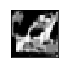

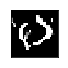

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 1.398987323045731e-02 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -4.864419400691986e-01 1.0e+00 9.45e-01  9e-01  9e-01 0:00.0
    3     45 -2.513755559921265e-01 1.0e+00 9.25e-01  9e-01  9e-01 0:00.0
WARNING (module=cma.utilities.utils, iteration=10):  flat fitness (sigma=8.32e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=10):  flat fitness (sigma=8.32e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=16):  flat fitness (sigma=7.92e-01).
                    For small sigma, this could indicate numerical convergence.
                    Oth

WARNING (module=cma.utilities.utils, iteration=40):  flat fitness (sigma=8.39e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=40):  flat fitness (sigma=8.39e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=42):  flat fitness (sigma=8.37e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=42):  flat fitness (sigma=8.37e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=60):  flat fitness (sigma=8.09e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=60):  flat fitness (sigma=8.09e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=61):  flat fitness (sigma=8.09e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=61):  flat fitness (sigma=8.09e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=76):  flat fitness (sigma=8.06e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=76):  flat fitness (sigma=8.06e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=77):  flat fitness (sigma=8.07e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=77):  flat fitness (sigma=8.07e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=92):  flat fitness (sigma=8.48e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=92):  flat fitness (sigma=8.48e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=93):  flat fitness (sigma=8.53e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=93):  flat fitness (sigma=8.53e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how t

WARNING (module=cma.utilities.utils, iteration=108):  flat fitness (sigma=8.97e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=108):  flat fitness (sigma=8.97e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=109):  flat fitness (sigma=8.99e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=109):  flat fitness (sigma=8.99e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=124):  flat fitness (sigma=9.18e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=124):  flat fitness (sigma=9.18e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=125):  flat fitness (sigma=9.17e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=125):  flat fitness (sigma=9.17e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=141):  flat fitness (sigma=8.96e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=141):  flat fitness (sigma=8.96e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=147):  flat fitness (sigma=8.66e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=147):  flat fitness (sigma=8.66e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=163):  flat fitness (sigma=8.09e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=163):  flat fitness (sigma=8.09e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=165):  flat fitness (sigma=8.05e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=165):  flat fitness (sigma=8.05e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=189):  flat fitness (sigma=7.49e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=189):  flat fitness (sigma=7.49e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=191):  flat fitness (sigma=7.45e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=191):  flat fitness (sigma=7.45e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=213):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=213):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=214):  flat fitness (sigma=7.65e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=214):  flat fitness (sigma=7.65e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=236):  flat fitness (sigma=7.28e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=236):  flat fitness (sigma=7.28e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=237):  flat fitness (sigma=7.28e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=237):  flat fitness (sigma=7.28e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=252):  flat fitness (sigma=7.23e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=252):  flat fitness (sigma=7.23e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=253):  flat fitness (sigma=7.22e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=253):  flat fitness (sigma=7.22e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=268):  flat fitness (sigma=7.63e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=268):  flat fitness (sigma=7.63e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=269):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
WARNING (module=cma.utilities.utils, iteration=269):  flat fitness (sigma=7.64e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider h

WARNING (module=cma.utilities.utils, iteration=284):  flat fitness (sigma=7.36e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.
  284   4260 -4.631068930029869e-02 1.4e+00 7.36e-01  7e-01  8e-01 0:04.2
WARNING (module=cma.utilities.utils, iteration=284):  flat fitness (sigma=7.36e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately.


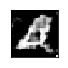

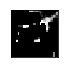

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.166399955749512e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -6.206053256988525e+00 1.0e+00 9.43e-01  9e-01  9e-01 0:00.0
    3     45 -3.642526626586914e+00 1.0e+00 9.23e-01  9e-01  9e-01 0:00.0
  100   1500 -2.763596916198730e+01 1.3e+00 6.83e-01  7e-01  7e-01 0:01.5
  200   3000 -3.283759307861328e+01 1.5e+00 5.40e-01  5e-01  6e-01 0:03.0
  300   4500 -3.585356140136719e+01 1.6e+00 3.42e-01  3e-01  4e-01 0:04.5
  400   6000 -3.671842956542969e+01 1.7e+00 2.95e-01  3e-01  3e-01 0:05.9
  500   7500 -3.816294479370117e+01 1.8e+00 2.24e-01  2e-01  2e-01 0:07.4


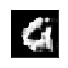

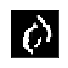

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -1.728438377380371e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -2.596028566360474e+00 1.0e+00 9.42e-01  9e-01  9e-01 0:00.0
    3     45 -3.827357053756714e+00 1.0e+00 9.21e-01  9e-01  9e-01 0:00.0
  100   1500 -3.431767654418945e+01 1.4e+00 7.45e-01  7e-01  8e-01 0:01.5
  200   3000 -3.601788330078125e+01 1.5e+00 5.77e-01  5e-01  6e-01 0:03.1
  300   4500 -3.730347061157227e+01 1.6e+00 4.62e-01  4e-01  5e-01 0:04.6
  400   6000 -3.837866592407227e+01 1.7e+00 3.38e-01  3e-01  3e-01 0:06.2
  500   7500 -3.936245727539062e+01 1.8e+00 2.36e-01  2e-01  2e-01 0:07.8


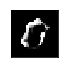

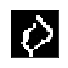

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -2.074395418167114e+00 1.0e+00 9.69e-01  1e+00  1e+00 0:00.0
    2     30 -4.965643405914307e+00 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -6.184556007385254e+00 1.0e+00 9.22e-01  9e-01  9e-01 0:00.0
  100   1500 -2.549295616149902e+01 1.3e+00 6.90e-01  7e-01  7e-01 0:01.4
  200   3000 -3.311063385009766e+01 1.4e+00 5.10e-01  5e-01  5e-01 0:03.0
  300   4500 -3.486276626586914e+01 1.5e+00 4.27e-01  4e-01  4e-01 0:04.5
  400   6000 -3.805642318725586e+01 1.6e+00 3.28e-01  3e-01  3e-01 0:06.0
  500   7500 -3.887348175048828e+01 1.7e+00 2.10e-01  2e-01  2e-01 0:07.6


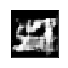

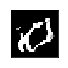

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 8.149648308753967e-01 1.0e+00 9.70e-01  1e+00  1e+00 0:00.0
    2     30 -9.840344190597534e-01 1.0e+00 9.44e-01  9e-01  9e-01 0:00.0
    3     45 -7.517176866531372e-01 1.0e+00 9.22e-01  9e-01  9e-01 0:00.1
  100   1500 -2.383522415161133e+01 1.3e+00 7.46e-01  7e-01  8e-01 0:01.5
  200   3000 -3.053973007202148e+01 1.5e+00 5.70e-01  6e-01  6e-01 0:03.0
  300   4500 -3.169709587097168e+01 1.6e+00 5.42e-01  5e-01  6e-01 0:04.5
  400   6000 -3.622009277343750e+01 1.7e+00 4.61e-01  4e-01  5e-01 0:06.0
  500   7500 -3.768333435058594e+01 1.7e+00 3.46e-01  3e-01  4e-01 0:07.6


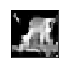

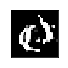

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -6.661231040954590e+00 1.0e+00 9.68e-01  1e+00  1e+00 0:00.0
    2     30 -8.459480285644531e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -5.250313758850098e+00 1.0e+00 9.18e-01  9e-01  9e-01 0:00.0
  100   1500 -2.562641716003418e+01 1.3e+00 7.34e-01  7e-01  7e-01 0:01.4
  200   3000 -3.263675308227539e+01 1.4e+00 5.69e-01  6e-01  6e-01 0:03.0
  300   4500 -3.477712631225586e+01 1.5e+00 4.45e-01  4e-01  5e-01 0:04.4
  400   6000 -3.681333923339844e+01 1.6e+00 3.05e-01  3e-01  3e-01 0:05.9
  500   7500 -3.952719497680664e+01 1.7e+00 3.22e-01  3e-01  3e-01 0:07.4


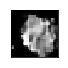

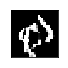

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 -3.463942766189575e+00 1.0e+00 9.67e-01  1e+00  1e+00 0:00.0
    2     30 -2.461062669754028e+00 1.0e+00 9.41e-01  9e-01  9e-01 0:00.0
    3     45 -1.940898656845093e+00 1.0e+00 9.17e-01  9e-01  9e-01 0:00.0
  100   1500 -2.939253425598145e+01 1.3e+00 7.06e-01  7e-01  7e-01 0:01.5
  200   3000 -3.191057395935059e+01 1.5e+00 6.28e-01  6e-01  6e-01 0:03.0
  300   4500 -3.514657592773438e+01 1.6e+00 4.93e-01  5e-01  5e-01 0:04.8
  400   6000 -3.614628982543945e+01 1.7e+00 4.09e-01  4e-01  4e-01 0:06.4
  500   7500 -3.797993850708008e+01 1.7e+00 3.69e-01  3e-01  4e-01 0:08.0


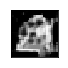

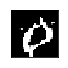

In [15]:
results = []
def cmaOptimize(sample,maxiter=500,popsize=15):
    es = cma.CMAEvolutionStrategy(sample.reshape(128),1,{'verbose':-3,'maxiter':maxiter,'popsize':popsize})
    i = 0
    resultsList=[sample.reshape(128)]
    while not es.stop():
        solutions = es.ask()
        es.tell(solutions, cmaObjective(np.array(solutions)))
        es.logger.add()  # write data to disc to be plotted
        es.disp()
        i+=1
        if i%100 == 0:
            resultsList+=[es.result[0]]
        
    print_codes(sample)
    print_codes(es.best.x)
    return resultsList
    return es.best.x
for i in range(0,100):
    #Thread(target=cmaOptimize,args=(mediums[i],)).start()
    results+=[cmaOptimize(mediums[i])]


(100, 4, 4, 8)


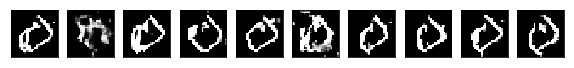

In [30]:
#np.array([x[-1] for x in results]).tofile("cmaresults.csv",sep=",")
cmaResults=np.genfromtxt("cmaresults.csv",delimiter=",").reshape(-1,4,4,8)
print(cmaResults.shape)
print_codes(results1[:10])

(42, 4, 4, 8)


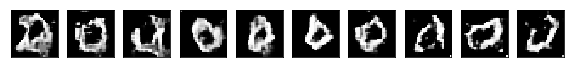

In [47]:
geneticResults=np.genfromtxt("geneticResults.csv",delimiter=",").reshape(-1,4,4,8)
print(geneticResults.shape)
print_codes(geneticResults[0:10])

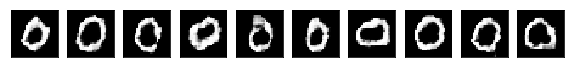

In [41]:
trainCodes = get_digits(encoded,0)
print_codes(trainCodes[:10])

In [48]:
def getAverageResults(codes):
    activations=getActivationsPre(codes)
    metrics=[metric(x,getActivationsPre) for x in codes]
    print("Activations:%.2f+-%.2f"% (np.mean(activations),np.std(activations)))
    print("Metric:%.2f+-%.2f"% (np.mean(metrics),np.std(metrics)))
    

getAverageResults(trainCodes[:100])
getAverageResults(mediums[:100])
getAverageResults(medium_opt[:100])
getAverageResults(cmaResults)
getAverageResults(geneticResults)


Activations:13.89+-3.41
Metric:12.38+-3.43
Activations:2.07+-1.66
Metric:0.64+-1.50
Activations:18.44+-4.98
Metric:12.68+-4.95
Activations:37.20+-9.67
Metric:36.10+-9.85
Activations:12.78+-1.91
Metric:9.45+-2.45


In [ ]:
def getActivations_no_activation(arr):
    return (generatorPre.predict(arr)*target_array).sum(axis=1)



for resultsList in results:
    plotHistory(resultsList)
    

In [ ]:
white_noise = encoder.predict(nrand.uniform(size=(10,28,28,1)))
results=[]
for i in range(0,10):
    #Thread(target=cmaOptimize,args=(mediums[i],)).start()
    results+=[cmaOptimize(white_noise[i])]

In [ ]:

    
for resultsList in results:
    plotHistory(resultsList)

In [ ]:
cmaOriginals,cmaFinished = zip(*results[:10])
print(cmaOriginals)
print_codes(np.array(cmaOriginals))
print_codes(np.array(cmaFinished))
np.array(cmaOriginals).tofile('originals.csv',sep=',')
np.array(cmaFinished).tofile('CMA.csv',sep=',')
print(getLL(np.array(cmaFinished)))

In [ ]:
genetic = []
for i in range(10):
    genetic+=[np.genfromtxt("Run 1/intermediate_{}_0.csv".format(10*i),delimiter=",")]
    
plotHistory(genetic)   
    
    
        
genetic = np.genfromtxt('bestRuns.csv', delimiter=',')
print(genetic.shape)
print_codes(genetic)

In [ ]:
mediums= np.array(cmaOriginals)
medium_opt=chartSamples(mediums,generator=generatorPre)


In [ ]:
singleHistory=np.array(medium_opt)[::100,0]
print singleHistory[1]==singleHistory[0]

In [ ]:
plotHistory(np.array(medium_opt)[::100,0])